# Omission LFP Analysis

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import glob
from collections import defaultdict
import re

In [3]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
import itertools

In [4]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp
from spectral_connectivity import Multitaper, Connectivity

## Inputs & Data

Explanation of each input and where it comes from.

In [5]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case

In [6]:
BBOX_TO_ANCHOR=(1.5, 0.9)
LOC='upper right'

In [7]:
# variables for LFP extraction
FREQ_MIN=0.5
FREQ_MAX=300
FREQ=60
RESAMPLE_RATE=1000
TRIAL_DURATION=10

In [8]:
INPUT_VARIABLE = 1

TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 3
TIME_WINDOW_STEP = 1.5 

TRIAL_TIME_STAMP_DURATION = 1000*10

In [9]:
BIN_TO_COLOR = {0: {"baseline": "lightblue", "trial": "blue"}, 1: {"baseline": "lightgreen", "trial": "green"}, 2: {"baseline": "lightcoral", "trial": "red"}}
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}
BIN_TO_VELOCITY = {0: "0 to 2.5cm/s", 1: "2.5 to 5cm/s", 2: "5cm/s to 10cm/s"}

In [10]:
BIN_TO_COLOR = {0: {"baseline": "lightblue", "trial": "blue"}, 1: {"baseline": "lightgreen", "trial": "green"}, 2: {"baseline": "lightcoral", "trial": "red"}}
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}
BIN_TO_VELOCITY = {0: "0 to 5cm/s", 1: "5cm/s to 10cm/s", 2: "10cm/s+"}

In [11]:
NUM_LINES = 3

In [12]:
# Generate colors from the "Blues" colormap
LOSING_COLORS = cm.Oranges(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
WINNING_COLORS = cm.Blues(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
REWARDED_COLORS = cm.Greens(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
OMISSION_COLORS = cm.Reds(np.linspace(0.5, 1, NUM_LINES))

In [13]:
BASELINE_OUTCOME_TO_COLOR = {'lose': "orange",
 'lose_baseline': LOSING_COLORS[0],
 'omission': "red",
 'omission_baseline': "hotpink",
 'rewarded': "green",
 'rewarded_baseline': REWARDED_COLORS[0],
 'win': "blue",
 'win_baseline': WINNING_COLORS[0]}

In [14]:
COMPETITIVE_OUTCOME_TO_COLOR = {'lose_comp': "orange", 
'lose_non_comp': "yellow",
'omission': "red",
'rewarded': "green",
'win_comp': "blue", 
'win_non_comp': WINNING_COLORS[0]}

In [15]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [16]:
CHANNEL_MAPPING_DF = pd.read_excel("./channel_mapping.xlsx")
CHANNEL_MAPPING_DF["Subject"] = CHANNEL_MAPPING_DF["Subject"].astype(str)

TONE_TIMESTAMP_DF = pd.read_excel("./rce_tone_timestamp.xlsx", index_col=0)
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs


In [17]:
ALL_SESSION_DIR = list(set(['/scratch/back_up/reward_competition_extention/data/omission/2023_06_17/20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_19/20230619_115321_standard_comp_to_omission_D3_subj_1-2_and_1-4.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_20/20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_21/20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2.rec'
                   ]))

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions

- Ideally functions are defined here first and then data is processed using the functions
    - function names are short and in snake case all lowercase
    - a function name should be unique but does not have to describe the function
    - doc strings describe functions not function names

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [18]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

In [19]:
CHANNEL_MAPPING_DF

Cohort Subject  eib_mPFC  eib_vHPC  eib_BLA  eib_LH  eib_MD  \
0       1     1.1       NaN        15       14      13      31   
1       1     1.2       NaN        15       14      13      31   
2       1     1.3       NaN        15       14      13      31   
3       1     1.4       NaN        15       14      13      31   
4       2     1.1       NaN        16       17      18      19   
5       2     1.2       NaN        31       30      29      28   
6       2     1.3       NaN        15       14      13      12   
7       2     1.4       NaN        15       14      13      12   

   spike_interface_mPFC  spike_interface_vHPC  spike_interface_BLA  \
0                   NaN                   NaN                  NaN   
1                   NaN                   NaN                  NaN   
2                   NaN                   NaN                  NaN   
3                   NaN                   NaN                  NaN   
4                   5.0                  31.0                 30.0   
5                  10.0                  31.0                 30.0   
6                   NaN                   NaN                  NaN   
7                   2.0                  31.0                 30.0   

   spike_interface_LH  spike_interface_MD  
0                 NaN                 NaN  
1                 NaN                 NaN  
2                 NaN                 NaN  
3                 NaN                 NaN  
4                29.0                28.0  
5                29.0                28.0  
6                 NaN                 NaN  
7                29.0                28.0

### Getting the subject IDs from the file name

In [20]:
TONE_TIMESTAMP_DF = pd.read_pickle("./proc/melted_trials_and_video.pkl")


In [21]:
all_trials_df = TONE_TIMESTAMP_DF.dropna(subset="condition").reset_index(drop=True)

In [22]:
all_trials_df.head()

time  state                                      recording_dir  \
0  4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
1  4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
2  6909411.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
3  6909411.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
4  9209413.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   

                                      recording_file           din  \
0  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
1  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
2  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
3  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
4  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0         1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
1         1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
2         3430878.0  20230617_115521_standard_comp_to_omission_D1_s...   
3         3430878.0  20230617_115521_standard_comp_to_omission_D1_s...   
4         5730880.0  20230617_115521_standard_comp_to_omission_D1_s...   

   video_frame  video_number    subject_info  ...  \
0         1029           1.0  1-1_t1b3L_box1  ...   
1         1029           1.0  1-1_t1b3L_box1  ...   
2         3425           1.0  1-1_t1b3L_box1  ...   
3         3425           1.0  1-1_t1b3L_box1  ...   
4         5720           1.0  1-1_t1b3L_box1  ...   

                       trial_chunked_ephys_timestamp  \
0  [(1030879.0, 1050879.0), (1050879.0, 1070879.0...   
1  [(1030879.0, 1050879.0), (1050879.0, 1070879.0...   
2  [(3430878.0, 3450878.0), (3450878.0, 3470878.0...   
3  [(3430878.0, 3450878.0), (3450878.0, 3470878.0...   
4  [(5730880.0, 5750880.0), (5750880.0, 5770880.0...   

                    baseline_chunked_ephys_timestamp  \
0  [(830879.0, 850879.0), (850879.0, 870879.0), (...   
1  [(830879.0, 850879.0), (850879.0, 870879.0), (...   
2  [(3230878.0, 3250878.0), (3250878.0, 3270878.0...   
3  [(3230878.0, 3250878.0), (3250878.0, 3270878.0...   
4  [(5530880.0, 5550880.0), (5550880.0, 5570880.0...   

                             trial_chunked_lfp_index  \
0  [(51543.0, 52543.0), (52543.0, 53543.0), (5354...   
1  [(51543.0, 52543.0), (52543.0, 53543.0), (5354...   
2  [(171543.0, 172543.0), (172543.0, 173543.0), (...   
3  [(171543.0, 172543.0), (172543.0, 173543.0), (...   
4  [(286544.0, 287544.0), (287544.0, 288544.0), (...   

                          baseline_chunked_lfp_index trial_or_baseline  \
0  [(41543.0, 42543.0), (42543.0, 43543.0), (4354...          baseline   
1  [(41543.0, 42543.0), (42543.0, 43543.0), (4354...             trial   
2  [(161543.0, 162543.0), (162543.0, 163543.0), (...          baseline   
3  [(161543.0, 162543.0), (162543.0, 163543.0), (...             trial   
4  [(276544.0, 277544.0), (277544.0, 278544.0), (...          baseline   

                             current_thorax_velocity  \
0  [1.740210085775107, 1.7046357778943324, 1.6492...   
1  [5.854587674773412, 5.491207535476736, 5.11749...   
2  [0.20814043433428542, 0.22314126629182324, 0.2...   
3  [2.3816625552688544, 2.3175606442761967, 2.218...   
4  [5.587991473689541, 5.787334491104469, 5.97825...   

                     current_chunked_thorax_velocity  \
0  [1.0482043233623093, 0.31708611003393056, 0.36...   
1  [4.204500001605147, 6.544647570039476, 1.57793...   
2  [0.24093936568383498, 0.1201192423141825, 0.23...   
3  [1.5520441045782087, 4.256821128528769, 11.997...   
4  [5.100726428703984, 3.878556470230757, 2.49962...   

                                   chunked_lfp_index  \
0  [(41543.0, 42543.0), (42543.0, 43543.0), (4354...   
1  [(51543.0, 52543.0), (52543.0, 53543.0), (5354...   
2  [(161543.0, 162543.0), (162543.0, 163543.0), (...   
3  [(171543.0, 172543.0)

- Original timestamps are based on ephys recordings at 20kHz. The LFP will be at 1kHz, so we will need to divide all the timestamps by 20

In [23]:
all_trials_df["resampled_index"] = all_trials_df["time_stamp_index"] // 20

In [24]:
all_trials_df["recording_dir"].unique()

array(['20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2',
       '20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-2_and_1-4',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2'],
      dtype=object)

- Getting a list of all the subjects through the recording name

In [25]:
all_trials_df["all_subjects"] = all_trials_df["recording_dir"].apply(lambda x: ["{}.{}".format(tup[0],tup[1]) for tup in re.findall(r'(\d+)-(\d+)', x.replace("_", "-"))[1:]])

In [26]:
all_trials_df["all_subjects"].head()

0    [1.1, 1.2]
1    [1.1, 1.2]
2    [1.1, 1.2]
3    [1.1, 1.2]
4    [1.1, 1.2]
Name: all_subjects, dtype: object

- Getting the current subject of the recording through the ending of the recording name file

In [27]:
all_trials_df["subject_info"].head()

0    1-1_t1b3L_box1
1    1-1_t1b3L_box1
2    1-1_t1b3L_box1
3    1-1_t1b3L_box1
4    1-1_t1b3L_box1
Name: subject_info, dtype: object

In [28]:
all_trials_df["current_subject"] = all_trials_df["subject_info"].apply(lambda x: ".".join(x.replace("-","_").split("_")[:2]))

In [29]:
all_trials_df.head()

time  state                                      recording_dir  \
0  4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
1  4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
2  6909411.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
3  6909411.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
4  9209413.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   

                                      recording_file           din  \
0  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
1  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
2  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
3  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
4  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0         1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
1         1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
2         3430878.0  20230617_115521_standard_comp_to_omission_D1_s...   
3         3430878.0  20230617_115521_standard_comp_to_omission_D1_s...   
4         5730880.0  20230617_115521_standard_comp_to_omission_D1_s...   

   video_frame  video_number    subject_info  ...  \
0         1029           1.0  1-1_t1b3L_box1  ...   
1         1029           1.0  1-1_t1b3L_box1  ...   
2         3425           1.0  1-1_t1b3L_box1  ...   
3         3425           1.0  1-1_t1b3L_box1  ...   
4         5720           1.0  1-1_t1b3L_box1  ...   

                       trial_chunked_ephys_timestamp  \
0  [(1030879.0, 1050879.0), (1050879.0, 1070879.0...   
1  [(1030879.0, 1050879.0), (1050879.0, 1070879.0...   
2  [(3430878.0, 3450878.0), (3450878.0, 3470878.0...   
3  [(3430878.0, 3450878.0), (3450878.0, 3470878.0...   
4  [(5730880.0, 5750880.0), (5750880.0, 5770880.0...   

                    baseline_chunked_ephys_timestamp  \
0  [(830879.0, 850879.0), (850879.0, 870879.0), (...   
1  [(830879.0, 850879.0), (850879.0, 870879.0), (...   
2  [(3230878.0, 3250878.0), (3250878.0, 3270878.0...   
3  [(3230878.0, 3250878.0), (3250878.0, 3270878.0...   
4  [(5530880.0, 5550880.0), (5550880.0, 5570880.0...   

                             trial_chunked_lfp_index  \
0  [(51543.0, 52543.0), (52543.0, 53543.0), (5354...   
1  [(51543.0, 52543.0), (52543.0, 53543.0), (5354...   
2  [(171543.0, 172543.0), (172543.0, 173543.0), (...   
3  [(171543.0, 172543.0), (172543.0, 173543.0), (...   
4  [(286544.0, 287544.0), (287544.0, 288544.0), (...   

                          baseline_chunked_lfp_index trial_or_baseline  \
0  [(41543.0, 42543.0), (42543.0, 43543.0), (4354...          baseline   
1  [(41543.0, 42543.0), (42543.0, 43543.0), (4354...             trial   
2  [(161543.0, 162543.0), (162543.0, 163543.0), (...          baseline   
3  [(161543.0, 162543.0), (162543.0, 163543.0), (...             trial   
4  [(276544.0, 277544.0), (277544.0, 278544.0), (...          baseline   

                             current_thorax_velocity  \
0  [1.740210085775107, 1.7046357778943324, 1.6492...   
1  [5.854587674773412, 5.491207535476736, 5.11749...   
2  [0.20814043433428542, 0.22314126629182324, 0.2...   
3  [2.3816625552688544, 2.3175606442761967, 2.218...   
4  [5.587991473689541, 5.787334491104469, 5.97825...   

                     current_chunked_thorax_velocity  \
0  [1.0482043233623093, 0.31708611003393056, 0.36...   
1  [4.204500001605147, 6.544647570039476, 1.57793...   
2  [0.24093936568383498, 0.1201192423141825, 0.23...   
3  [1.5520441045782087, 4.256821128528769, 11.997...   
4  [5.100726428703984, 3.878556470230757, 2.49962...   

                                   chunked_lfp_index  \
0  [(41543.0, 42543.0), (42543.0, 43543.0), (4354...   
1  [(51543.0, 52543.0), (52543.0, 53543.0), (5354...   
2  [(161543.0, 162543.0), (162543.0, 163543.0), (...   
3  [(171543.0, 172543.0)

- Labeling the trial as a winner or loser if the winner matches the subject id or not

In [30]:
all_trials_df["trial_outcome"] = all_trials_df.apply(
    lambda x: "win" if str(x["condition"]).strip() == str(x["current_subject"]) 
             else ("lose" if str(x["condition"]) in x["all_subjects"] 
                   else x["condition"]), axis=1)

In [31]:
all_trials_df.head()

time  state                                      recording_dir  \
0  4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
1  4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
2  6909411.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
3  6909411.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
4  9209413.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   

                                      recording_file           din  \
0  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
1  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
2  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
3  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
4  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0         1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
1         1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
2         3430878.0  20230617_115521_standard_comp_to_omission_D1_s...   
3         3430878.0  20230617_115521_standard_comp_to_omission_D1_s...   
4         5730880.0  20230617_115521_standard_comp_to_omission_D1_s...   

   video_frame  video_number    subject_info  ...  \
0         1029           1.0  1-1_t1b3L_box1  ...   
1         1029           1.0  1-1_t1b3L_box1  ...   
2         3425           1.0  1-1_t1b3L_box1  ...   
3         3425           1.0  1-1_t1b3L_box1  ...   
4         5720           1.0  1-1_t1b3L_box1  ...   

                       trial_chunked_ephys_timestamp  \
0  [(1030879.0, 1050879.0), (1050879.0, 1070879.0...   
1  [(1030879.0, 1050879.0), (1050879.0, 1070879.0...   
2  [(3430878.0, 3450878.0), (3450878.0, 3470878.0...   
3  [(3430878.0, 3450878.0), (3450878.0, 3470878.0...   
4  [(5730880.0, 5750880.0), (5750880.0, 5770880.0...   

                    baseline_chunked_ephys_timestamp  \
0  [(830879.0, 850879.0), (850879.0, 870879.0), (...   
1  [(830879.0, 850879.0), (850879.0, 870879.0), (...   
2  [(3230878.0, 3250878.0), (3250878.0, 3270878.0...   
3  [(3230878.0, 3250878.0), (3250878.0, 3270878.0...   
4  [(5530880.0, 5550880.0), (5550880.0, 5570880.0...   

                             trial_chunked_lfp_index  \
0  [(51543.0, 52543.0), (52543.0, 53543.0), (5354...   
1  [(51543.0, 52543.0), (52543.0, 53543.0), (5354...   
2  [(171543.0, 172543.0), (172543.0, 173543.0), (...   
3  [(171543.0, 172543.0), (172543.0, 173543.0), (...   
4  [(286544.0, 287544.0), (287544.0, 288544.0), (...   

                          baseline_chunked_lfp_index trial_or_baseline  \
0  [(41543.0, 42543.0), (42543.0, 43543.0), (4354...          baseline   
1  [(41543.0, 42543.0), (42543.0, 43543.0), (4354...             trial   
2  [(161543.0, 162543.0), (162543.0, 163543.0), (...          baseline   
3  [(161543.0, 162543.0), (162543.0, 163543.0), (...             trial   
4  [(276544.0, 277544.0), (277544.0, 278544.0), (...          baseline   

                             current_thorax_velocity  \
0  [1.740210085775107, 1.7046357778943324, 1.6492...   
1  [5.854587674773412, 5.491207535476736, 5.11749...   
2  [0.20814043433428542, 0.22314126629182324, 0.2...   
3  [2.3816625552688544, 2.3175606442761967, 2.218...   
4  [5.587991473689541, 5.787334491104469, 5.97825...   

                     current_chunked_thorax_velocity  \
0  [1.0482043233623093, 0.31708611003393056, 0.36...   
1  [4.204500001605147, 6.544647570039476, 1.57793...   
2  [0.24093936568383498, 0.1201192423141825, 0.23...   
3  [1.5520441045782087, 4.256821128528769, 11.997...   
4  [5.100726428703984, 3.878556470230757, 2.49962...   

                                   chunked_lfp_index  \
0  [(41543.0, 42543.0), (42543.0, 43543.0), (4354...   
1  [(51543.0, 52543.0), (52543.0, 53543.0), (5354...   
2  [(161543.0, 162543.0), (162543.0, 163543.0), (...   
3  [(171543.0, 172543.0)

In [32]:
competition_closeness_map = {k: "non_comp" if "only" in str(k).lower() else "comp" if type(k) is str else np.nan for k in all_trials_df["competition_closeness"].unique()}

In [33]:
competition_closeness_map

{'Subj 2 blocking Subj 1': 'comp',
 'Subj 1 blocking Subj 2': 'comp',
 'Subj 2 Only': 'non_comp',
 'Subj 1 Only': 'non_comp',
 'Subj 1 then Subj 2': 'comp',
 'Subj 2 then Subj 1': 'comp',
 'Close Call': 'comp',
 nan: nan}

In [34]:
all_trials_df["competition_closeness"] = all_trials_df["competition_closeness"].map(competition_closeness_map)

In [35]:
all_trials_df["competition_closeness"]

0      comp
1      comp
2      comp
3      comp
4      comp
       ... 
475     NaN
476     NaN
477     NaN
478     NaN
479     NaN
Name: competition_closeness, Length: 480, dtype: object

In [36]:
all_trials_df["competition_closeness"] = all_trials_df.apply(lambda x: "_".join([str(x["trial_outcome"]), str(x["competition_closeness"])]).strip("nan").strip("_"), axis=1)

### Extracting the LFP

In [37]:
recording_name_to_all_ch_lfp = {}
# Going through all the recording sessions 
for session_dir in ALL_SESSION_DIR:
    # Going through all the recordings in each session
    for recording_path in glob.glob(os.path.join(session_dir, "*.rec")):
        try:
            recording_basename = os.path.splitext(os.path.basename(recording_path))[0]
            # checking to see if the recording has an ECU component
            # if it doesn't, then the next one be extracted
            current_recording = se.read_spikegadgets(recording_path, stream_id="ECU")
            current_recording = se.read_spikegadgets(recording_path, stream_id="trodes")
            print(recording_basename)
            # Preprocessing the LFP
            current_recording = sp.bandpass_filter(current_recording, freq_min=0.5, freq_max=300)
            current_recording = sp.notch_filter(current_recording, freq=60)
            current_recording = sp.resample(current_recording, resample_rate=1000)
            current_recording = sp.zscore(current_recording)
            recording_name_to_all_ch_lfp[recording_basename] = current_recording
        except:
            pass



20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged


- Filtering for all trials that have labels

In [38]:
all_trials_df = all_trials_df[all_trials_df["recording_file"].isin(recording_name_to_all_ch_lfp.keys())].reset_index(drop=True)

In [39]:
all_trials_df.head()

time  state                                      recording_dir  \
0  4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
1  4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
2  6909411.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
3  6909411.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
4  9209413.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   

                                      recording_file           din  \
0  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
1  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
2  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
3  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
4  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0         1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
1         1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
2         3430878.0  20230617_115521_standard_comp_to_omission_D1_s...   
3         3430878.0  20230617_115521_standard_comp_to_omission_D1_s...   
4         5730880.0  20230617_115521_standard_comp_to_omission_D1_s...   

   video_frame  video_number    subject_info  ...  \
0         1029           1.0  1-1_t1b3L_box1  ...   
1         1029           1.0  1-1_t1b3L_box1  ...   
2         3425           1.0  1-1_t1b3L_box1  ...   
3         3425           1.0  1-1_t1b3L_box1  ...   
4         5720           1.0  1-1_t1b3L_box1  ...   

                       trial_chunked_ephys_timestamp  \
0  [(1030879.0, 1050879.0), (1050879.0, 1070879.0...   
1  [(1030879.0, 1050879.0), (1050879.0, 1070879.0...   
2  [(3430878.0, 3450878.0), (3450878.0, 3470878.0...   
3  [(3430878.0, 3450878.0), (3450878.0, 3470878.0...   
4  [(5730880.0, 5750880.0), (5750880.0, 5770880.0...   

                    baseline_chunked_ephys_timestamp  \
0  [(830879.0, 850879.0), (850879.0, 870879.0), (...   
1  [(830879.0, 850879.0), (850879.0, 870879.0), (...   
2  [(3230878.0, 3250878.0), (3250878.0, 3270878.0...   
3  [(3230878.0, 3250878.0), (3250878.0, 3270878.0...   
4  [(5530880.0, 5550880.0), (5550880.0, 5570880.0...   

                             trial_chunked_lfp_index  \
0  [(51543.0, 52543.0), (52543.0, 53543.0), (5354...   
1  [(51543.0, 52543.0), (52543.0, 53543.0), (5354...   
2  [(171543.0, 172543.0), (172543.0, 173543.0), (...   
3  [(171543.0, 172543.0), (172543.0, 173543.0), (...   
4  [(286544.0, 287544.0), (287544.0, 288544.0), (...   

                          baseline_chunked_lfp_index trial_or_baseline  \
0  [(41543.0, 42543.0), (42543.0, 43543.0), (4354...          baseline   
1  [(41543.0, 42543.0), (42543.0, 43543.0), (4354...             trial   
2  [(161543.0, 162543.0), (162543.0, 163543.0), (...          baseline   
3  [(161543.0, 162543.0), (162543.0, 163543.0), (...             trial   
4  [(276544.0, 277544.0), (277544.0, 278544.0), (...          baseline   

                             current_thorax_velocity  \
0  [1.740210085775107, 1.7046357778943324, 1.6492...   
1  [5.854587674773412, 5.491207535476736, 5.11749...   
2  [0.20814043433428542, 0.22314126629182324, 0.2...   
3  [2.3816625552688544, 2.3175606442761967, 2.218...   
4  [5.587991473689541, 5.787334491104469, 5.97825...   

                     current_chunked_thorax_velocity  \
0  [1.0482043233623093, 0.31708611003393056, 0.36...   
1  [4.204500001605147, 6.544647570039476, 1.57793...   
2  [0.24093936568383498, 0.1201192423141825, 0.23...   
3  [1.5520441045782087, 4.256821128528769, 11.997...   
4  [5.100726428703984, 3.878556470230757, 2.49962...   

                                   chunked_lfp_index  \
0  [(41543.0, 42543.0), (42543.0, 43543.0), (4354...   
1  [(51543.0, 52543.0), (52543.0, 53543.0), (5354...   
2  [(161543.0, 162543.0), (162543.0, 163543.0), (...   
3  [(171543.0, 172543.0)

In [40]:
all_trials_df["trial_outcome"].unique()

array(['lose', 'win', 'rewarded', 'omission'], dtype=object)

In [41]:
all_trials_df["trial_or_baseline"].unique()

array(['baseline', 'trial'], dtype=object)

In [42]:
recording_name_to_all_ch_lfp.keys()

dict_keys(['20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged', '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged', '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged', '20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged', '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged', '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged', '20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged', '20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged'])

In [43]:
CHANNEL_MAPPING_DF

Cohort Subject  eib_mPFC  eib_vHPC  eib_BLA  eib_LH  eib_MD  \
0       1     1.1       NaN        15       14      13      31   
1       1     1.2       NaN        15       14      13      31   
2       1     1.3       NaN        15       14      13      31   
3       1     1.4       NaN        15       14      13      31   
4       2     1.1       NaN        16       17      18      19   
5       2     1.2       NaN        31       30      29      28   
6       2     1.3       NaN        15       14      13      12   
7       2     1.4       NaN        15       14      13      12   

   spike_interface_mPFC  spike_interface_vHPC  spike_interface_BLA  \
0                   NaN                   NaN                  NaN   
1                   NaN                   NaN                  NaN   
2                   NaN                   NaN                  NaN   
3                   NaN                   NaN                  NaN   
4                   5.0                  31.0                 30.0   
5                  10.0                  31.0                 30.0   
6                   NaN                   NaN                  NaN   
7                   2.0                  31.0                 30.0   

   spike_interface_LH  spike_interface_MD  
0                 NaN                 NaN  
1                 NaN                 NaN  
2                 NaN                 NaN  
3                 NaN                 NaN  
4                29.0                28.0  
5                29.0                28.0  
6                 NaN                 NaN  
7                29.0                28.0

## Power Calculation

In [44]:
all_trials_df.head()

time  state                                      recording_dir  \
0  4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
1  4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
2  6909411.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
3  6909411.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
4  9209413.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   

                                      recording_file           din  \
0  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
1  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
2  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
3  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
4  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0         1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
1         1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
2         3430878.0  20230617_115521_standard_comp_to_omission_D1_s...   
3         3430878.0  20230617_115521_standard_comp_to_omission_D1_s...   
4         5730880.0  20230617_115521_standard_comp_to_omission_D1_s...   

   video_frame  video_number    subject_info  ...  \
0         1029           1.0  1-1_t1b3L_box1  ...   
1         1029           1.0  1-1_t1b3L_box1  ...   
2         3425           1.0  1-1_t1b3L_box1  ...   
3         3425           1.0  1-1_t1b3L_box1  ...   
4         5720           1.0  1-1_t1b3L_box1  ...   

                       trial_chunked_ephys_timestamp  \
0  [(1030879.0, 1050879.0), (1050879.0, 1070879.0...   
1  [(1030879.0, 1050879.0), (1050879.0, 1070879.0...   
2  [(3430878.0, 3450878.0), (3450878.0, 3470878.0...   
3  [(3430878.0, 3450878.0), (3450878.0, 3470878.0...   
4  [(5730880.0, 5750880.0), (5750880.0, 5770880.0...   

                    baseline_chunked_ephys_timestamp  \
0  [(830879.0, 850879.0), (850879.0, 870879.0), (...   
1  [(830879.0, 850879.0), (850879.0, 870879.0), (...   
2  [(3230878.0, 3250878.0), (3250878.0, 3270878.0...   
3  [(3230878.0, 3250878.0), (3250878.0, 3270878.0...   
4  [(5530880.0, 5550880.0), (5550880.0, 5570880.0...   

                             trial_chunked_lfp_index  \
0  [(51543.0, 52543.0), (52543.0, 53543.0), (5354...   
1  [(51543.0, 52543.0), (52543.0, 53543.0), (5354...   
2  [(171543.0, 172543.0), (172543.0, 173543.0), (...   
3  [(171543.0, 172543.0), (172543.0, 173543.0), (...   
4  [(286544.0, 287544.0), (287544.0, 288544.0), (...   

                          baseline_chunked_lfp_index trial_or_baseline  \
0  [(41543.0, 42543.0), (42543.0, 43543.0), (4354...          baseline   
1  [(41543.0, 42543.0), (42543.0, 43543.0), (4354...             trial   
2  [(161543.0, 162543.0), (162543.0, 163543.0), (...          baseline   
3  [(161543.0, 162543.0), (162543.0, 163543.0), (...             trial   
4  [(276544.0, 277544.0), (277544.0, 278544.0), (...          baseline   

                             current_thorax_velocity  \
0  [1.740210085775107, 1.7046357778943324, 1.6492...   
1  [5.854587674773412, 5.491207535476736, 5.11749...   
2  [0.20814043433428542, 0.22314126629182324, 0.2...   
3  [2.3816625552688544, 2.3175606442761967, 2.218...   
4  [5.587991473689541, 5.787334491104469, 5.97825...   

                     current_chunked_thorax_velocity  \
0  [1.0482043233623093, 0.31708611003393056, 0.36...   
1  [4.204500001605147, 6.544647570039476, 1.57793...   
2  [0.24093936568383498, 0.1201192423141825, 0.23...   
3  [1.5520441045782087, 4.256821128528769, 11.997...   
4  [5.100726428703984, 3.878556470230757, 2.49962...   

                                   chunked_lfp_index  \
0  [(41543.0, 42543.0), (42543.0, 43543.0), (4354...   
1  [(51543.0, 52543.0), (52543.0, 53543.0), (5354...   
2  [(161543.0, 162543.0), (162543.0, 163543.0), (...   
3  [(171543.0, 172543.0)

- Adding all the brain region to ch information

In [45]:
channel_map_and_all_trials_df = all_trials_df.merge(CHANNEL_MAPPING_DF, left_on="current_subject", right_on="Subject", how="left")

- Linking up all LFP calculations with all the trials

In [46]:
channel_map_and_all_trials_df["all_ch_lfp"] = channel_map_and_all_trials_df["recording_file"].map(recording_name_to_all_ch_lfp)

- Creating a new row for each brain region

In [47]:
brain_region_col = [col for col in CHANNEL_MAPPING_DF if "spike_interface" in col]

In [48]:
id_cols = [col for col in channel_map_and_all_trials_df.columns if col not in brain_region_col]

In [49]:
melted_channel_map_and_all_trials_df = channel_map_and_all_trials_df.melt(id_vars=id_cols ,value_vars=brain_region_col, var_name='brain_region', value_name='channel')


In [50]:
melted_channel_map_and_all_trials_df.head()

time  state                                      recording_dir  \
0  4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
1  4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
2  4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
3  4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
4  6909411.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   

                                      recording_file           din  \
0  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
1  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
2  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
3  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
4  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0         1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
1         1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
2         1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
3         1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
4         3430878.0  20230617_115521_standard_comp_to_omission_D1_s...   

   video_frame  video_number    subject_info  ... Cohort Subject eib_mPFC  \
0         1029           1.0  1-1_t1b3L_box1  ...      1     1.1      NaN   
1         1029           1.0  1-1_t1b3L_box1  ...      2     1.1      NaN   
2         1029           1.0  1-1_t1b3L_box1  ...      1     1.1      NaN   
3         1029           1.0  1-1_t1b3L_box1  ...      2     1.1      NaN   
4         3425           1.0  1-1_t1b3L_box1  ...      1     1.1      NaN   

   eib_vHPC eib_BLA eib_LH eib_MD  \
0        15      14     13     31   
1        16      17     18     19   
2        15      14     13     31   
3        16      17     18     19   
4        15      14     13     31   

                                          all_ch_lfp          brain_region  \
0  ZScoreRecording: 32 channels - 1 segments - 1....  spike_interface_mPFC   
1  ZScoreRecording: 32 channels - 1 segments - 1....  spike_interface_mPFC   
2  ZScoreRecording: 32 channels - 1 segments - 1....  spike_interface_mPFC   
3  ZScoreRecording: 32 channels - 1 segments - 1....  spike_interface_mPFC   
4  ZScoreRecording: 32 channels - 1 segments - 1....  spike_interface_mPFC   

   channel  
0      NaN  
1      5.0  
2      NaN  
3      5.0  
4      NaN  

[5 rows x 72 columns]

In [51]:
melted_channel_map_and_all_trials_df.tail()

time  state                                      recording_dir  \
4795  70681909.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   
4796  71681918.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   
4797  71681918.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   
4798  71681918.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   
4799  71681918.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   

                                         recording_file           din  \
4795  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   
4796  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   
4797  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   
4798  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   
4799  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   

      time_stamp_index                                         video_file  \
4795        67488865.0  20230621_111240_standard_comp_to_omission_D5_s...   
4796        68488874.0  20230621_111240_standard_comp_to_omission_D5_s...   
4797        68488874.0  20230621_111240_standard_comp_to_omission_D5_s...   
4798        68488874.0  20230621_111240_standard_comp_to_omission_D5_s...   
4799        68488874.0  20230621_111240_standard_comp_to_omission_D5_s...   

      video_frame  video_number    subject_info  ... Cohort Subject eib_mPFC  \
4795        67447           1.0  1-4_t3b3L_box1  ...      2     1.4      NaN   
4796        68444           1.0  1-4_t3b3L_box1  ...      1     1.4      NaN   
4797        68444           1.0  1-4_t3b3L_box1  ...      2     1.4      NaN   
4798        68444           1.0  1-4_t3b3L_box1  ...      1     1.4      NaN   
4799        68444           1.0  1-4_t3b3L_box1  ...      2     1.4      NaN   

      eib_vHPC eib_BLA eib_LH eib_MD  \
4795        15      14     13     12   
4796        15      14     13     31   
4797        15      14     13     12   
4798        15      14     13     31   
4799        15      14     13     12   

                                             all_ch_lfp        brain_region  \
4795  ZScoreRecording: 32 channels - 1 segments - 1....  spike_interface_MD   
4796  ZScoreRecording: 32 channels - 1 segments - 1....  spike_interface_MD   
4797  ZScoreRecording: 32 channels - 1 segments - 1....  spike_interface_MD   
4798  ZScoreRecording: 32 channels - 1 segments - 1....  spike_interface_MD   
4799  ZScoreRecording: 32 channels - 1 segments - 1....  spike_interface_MD   

      channel  
4795     28.0  
4796      NaN  
4797     28.0  
4798      NaN  
4799     28.0  

[5 rows x 72 columns]

- Getting the traces for each trial for each brain region

In [52]:
melted_channel_map_and_all_trials_df = melted_channel_map_and_all_trials_df.dropna(subset=["channel"])

In [53]:
melted_channel_map_and_all_trials_df["channel"] = melted_channel_map_and_all_trials_df["channel"].astype(int).astype(str)
melted_channel_map_and_all_trials_df["resampled_index"] = melted_channel_map_and_all_trials_df["resampled_index"].astype(int)

In [54]:
melted_channel_map_and_all_trials_df["chunked_lfp_index"].iloc[0]

[(41543.0, 42543.0),
 (42543.0, 43543.0),
 (43543.0, 44543.0),
 (44543.0, 45543.0),
 (45543.0, 46543.0),
 (46543.0, 47543.0),
 (47543.0, 48543.0),
 (48543.0, 49543.0),
 (49543.0, 50543.0),
 (50543.0, 51543.0)]

In [55]:
melted_channel_map_and_all_trials_df["binned_current_thorax_velocity"].iloc[0]

[0, 0, 0, 0, 0, 0, 0, 2, 2, 1]

In [56]:
melted_channel_map_and_all_trials_df["chunked_current_trace"] = melted_channel_map_and_all_trials_df.apply(lambda x: 
[x["all_ch_lfp"].get_traces(channel_ids=[x["channel"]], start_frame=chunk_index[0], end_frame=chunk_index[1]).T[0] for chunk_index in x["chunked_lfp_index"]], axis=1)

In [57]:
len(melted_channel_map_and_all_trials_df["chunked_current_trace"].iloc[0])

10

In [58]:
melted_channel_map_and_all_trials_df["chunked_current_trace"]

1       [[-1.6380714, -1.7383615, -1.9704052, -1.90157...
3       [[-1.0166662, -0.7177624, -0.6391035, -1.07959...
5       [[0.3401997, 0.35789797, 0.53488046, 0.5722434...
7       [[-0.62140524, -0.40705976, -0.12978718, 0.192...
9       [[1.8524169, 1.8701152, 1.8130875, 1.5554796, ...
                              ...                        
4791    [[-0.9353915, -1.0308397, -0.97357076, -0.5408...
4793    [[1.6671604, 1.5685307, 1.3839977, 1.823059, 2...
4795    [[0.3404316, 0.35315803, 0.21953066, -0.283162...
4797    [[-0.62359434, -0.009544811, 0.52496463, 0.668...
4799    [[0.06681368, 0.4326981, 0.658592, 0.64586556,...
Name: chunked_current_trace, Length: 2400, dtype: object

In [59]:
melted_channel_map_and_all_trials_df["chunk_id"] = [list(range(0,10))] * len(melted_channel_map_and_all_trials_df)

In [60]:
exploded_channel_map_and_all_trials_df = melted_channel_map_and_all_trials_df.explode(["current_chunked_thorax_velocity", "chunked_current_trace", "binned_current_thorax_velocity", "chunked_lfp_index",	"chunked_ephys_timestamp", "chunk_id"])

In [61]:
exploded_channel_map_and_all_trials_df

time  state                                      recording_dir  \
1      4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
1      4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
1      4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
1      4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
1      4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
...          ...    ...                                                ...   
4799  71681918.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   
4799  71681918.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   
4799  71681918.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   
4799  71681918.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   
4799  71681918.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   

                                         recording_file           din  \
1     20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
1     20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
1     20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
1     20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
1     20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
...                                                 ...           ...   
4799  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   
4799  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   
4799  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   
4799  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   
4799  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   

      time_stamp_index                                         video_file  \
1            1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
1            1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
1            1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
1            1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
1            1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
...                ...                                                ...   
4799        68488874.0  20230621_111240_standard_comp_to_omission_D5_s...   
4799        68488874.0  20230621_111240_standard_comp_to_omission_D5_s...   
4799        68488874.0  20230621_111240_standard_comp_to_omission_D5_s...   
4799        68488874.0  20230621_111240_standard_comp_to_omission_D5_s...   
4799        68488874.0  20230621_111240_standard_comp_to_omission_D5_s...   

      video_frame  video_number    subject_info  ... eib_mPFC eib_vHPC  \
1            1029           1.0  1-1_t1b3L_box1  ...      NaN       16   
1            1029           1.0  1-1_t1b3L_box1  ...      NaN       16   
1            1029           1.0  1-1_t1b3L_box1  ...      NaN       16   
1            1029           1.0  1-1_t1b3L_box1  ...      NaN       16   
1            1029           1.0  1-1_t1b3L_box1  ...      NaN       16   
...           ...           ...             ...  ...      ...      ...   
4799        68444           1.0  1-4_t3b3L_box1  ...      NaN       15   
4799        68444           1.0  1-4_t3b3L_box1  ...      NaN       15   
4799        68444           1.0  1-4_t3b3L_box1  ...      NaN       15   
4799        68444           1.0  1-4_t3b3L_box1  ...      NaN       15   
4799        68444           1.0  1-4_t3b3L_box1  ...      NaN       15   

     eib_BLA  eib_LH eib_MD  \
1         17      18     19   
1         17      18     19   
1         17      18     19   
1         17      18     19   
1         17      18     19   
...      ...     ...    ...   
4799      14      13     12   
4799      14      13     12   
4799      14      13     12   
4799      14      13     12   
4799      14      13     12   

           

In [62]:
exploded_channel_map_and_all_trials_df["len_chunked_current_trace"] = exploded_channel_map_and_all_trials_df["chunked_current_trace"].apply(lambda x: len(x))


In [63]:
exploded_channel_map_and_all_trials_df["len_chunked_current_trace"].unique()

array([1000, 1001])

In [64]:
exploded_channel_map_and_all_trials_df["chunked_current_trace"] = exploded_channel_map_and_all_trials_df["chunked_current_trace"].apply(lambda x: x[:RESAMPLE_RATE])

In [65]:
exploded_channel_map_and_all_trials_df["chunked_current_trace"]

1       [-1.6380714, -1.7383615, -1.9704052, -1.901578...
1       [1.7698251, 1.8642157, 1.8229198, 1.4217595, 0...
1       [2.2634096, 2.2044156, 1.9330423, 1.5712113, 1...
1       [-0.61157286, -1.1012245, -1.4079942, -1.43749...
1       [-0.98126966, -0.9655379, -0.93407434, -1.2526...
                              ...                        
4799    [0.18453301, -0.31816038, -0.88130426, -1.2599...
4799    [-0.31179717, -0.49951178, -0.48042217, -0.318...
4799    [-0.9862972, -1.027658, -0.9926604, -0.9322099...
4799    [1.8612382, 1.9789575, 2.3893845, 2.5834622, 2...
4799    [1.533533, 1.5621674, 1.5653491, 1.5526227, 1....
Name: chunked_current_trace, Length: 24000, dtype: object

- Calcuating the power at each frequency band

In [66]:
exploded_channel_map_and_all_trials_df["multitaper"] = exploded_channel_map_and_all_trials_df["chunked_current_trace"].apply(lambda x: Multitaper(time_series=x,                                                                                        sampling_frequency=RESAMPLE_RATE))

In [67]:
exploded_channel_map_and_all_trials_df["connectivity"] = exploded_channel_map_and_all_trials_df["multitaper"].apply(lambda x: Connectivity.from_multitaper(x))

In [68]:
exploded_channel_map_and_all_trials_df["frequencies"] = exploded_channel_map_and_all_trials_df["connectivity"].apply(lambda x: x.frequencies)

In [69]:
exploded_channel_map_and_all_trials_df["power"] = exploded_channel_map_and_all_trials_df["connectivity"].apply(lambda x: x.power().squeeze())

In [70]:
exploded_channel_map_and_all_trials_df.head()

time  state                                      recording_dir  \
1  4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
1  4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
1  4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
1  4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
1  4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   

                                      recording_file           din  \
1  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
1  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
1  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
1  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
1  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
1         1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
1         1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
1         1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
1         1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
1         1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   

   video_frame  video_number    subject_info  ...  \
1         1029           1.0  1-1_t1b3L_box1  ...   
1         1029           1.0  1-1_t1b3L_box1  ...   
1         1029           1.0  1-1_t1b3L_box1  ...   
1         1029           1.0  1-1_t1b3L_box1  ...   
1         1029           1.0  1-1_t1b3L_box1  ...   

                                          all_ch_lfp          brain_region  \
1  ZScoreRecording: 32 channels - 1 segments - 1....  spike_interface_mPFC   
1  ZScoreRecording: 32 channels - 1 segments - 1....  spike_interface_mPFC   
1  ZScoreRecording: 32 channels - 1 segments - 1....  spike_interface_mPFC   
1  ZScoreRecording: 32 channels - 1 segments - 1....  spike_interface_mPFC   
1  ZScoreRecording: 32 channels - 1 segments - 1....  spike_interface_mPFC   

  channel                              chunked_current_trace chunk_id  \
1       5  [-1.6380714, -1.7383615, -1.9704052, -1.901578...        0   
1       5  [1.7698251, 1.8642157, 1.8229198, 1.4217595, 0...        1   
1       5  [2.2634096, 2.2044156, 1.9330423, 1.5712113, 1...        2   
1       5  [-0.61157286, -1.1012245, -1.4079942, -1.43749...        3   
1       5  [-0.98126966, -0.9655379, -0.93407434, -1.2526...        4   

  len_chunked_current_trace  \
1                      1000   
1                      1000   
1                      1000   
1                      1000   
1                      1000   

                                          multitaper  \
1  Multitaper(sampling_frequency=1000, time_halfb...   
1  Multitaper(sampling_frequency=1000, time_halfb...   
1  Multitaper(sampling_frequency=1000, time_halfb...   
1  Multitaper(sampling_frequency=1000, time_halfb...   
1  Multitaper(sampling_frequency=1000, time_halfb...   

                                        connectivity  \
1  <spectral_connectivity.connectivity.Connectivi...   
1  <spectral_connectivity.connectivity.Connectivi...   
1  <spectral_connectivity.connectivity.Connectivi...   
1  <spectral_connectivity.connectivity.Connectivi...   
1  <spectral_connectivity.connectivity.Connectivi...   

                                         frequencies  \
1  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
1  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
1  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
1  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
1  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   

                                               power  
1  [0.13849083649217706, 0.12413016979887025, 0.1...  
1  [0.01437127936451168, 0.011455511174182078, 0....  
1  [0.01191138331412541, 0.018479671376279695, 0....  
1  [0.02542437000749434, 0.015909740675252033, 0....

In [71]:
exploded_channel_map_and_all_trials_df.tail()

time  state                                      recording_dir  \
4799  71681918.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   
4799  71681918.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   
4799  71681918.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   
4799  71681918.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   
4799  71681918.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   

                                         recording_file           din  \
4799  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   
4799  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   
4799  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   
4799  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   
4799  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   

      time_stamp_index                                         video_file  \
4799        68488874.0  20230621_111240_standard_comp_to_omission_D5_s...   
4799        68488874.0  20230621_111240_standard_comp_to_omission_D5_s...   
4799        68488874.0  20230621_111240_standard_comp_to_omission_D5_s...   
4799        68488874.0  20230621_111240_standard_comp_to_omission_D5_s...   
4799        68488874.0  20230621_111240_standard_comp_to_omission_D5_s...   

      video_frame  video_number    subject_info  ...  \
4799        68444           1.0  1-4_t3b3L_box1  ...   
4799        68444           1.0  1-4_t3b3L_box1  ...   
4799        68444           1.0  1-4_t3b3L_box1  ...   
4799        68444           1.0  1-4_t3b3L_box1  ...   
4799        68444           1.0  1-4_t3b3L_box1  ...   

                                             all_ch_lfp        brain_region  \
4799  ZScoreRecording: 32 channels - 1 segments - 1....  spike_interface_MD   
4799  ZScoreRecording: 32 channels - 1 segments - 1....  spike_interface_MD   
4799  ZScoreRecording: 32 channels - 1 segments - 1....  spike_interface_MD   
4799  ZScoreRecording: 32 channels - 1 segments - 1....  spike_interface_MD   
4799  ZScoreRecording: 32 channels - 1 segments - 1....  spike_interface_MD   

     channel                              chunked_current_trace chunk_id  \
4799      28  [0.18453301, -0.31816038, -0.88130426, -1.2599...        5   
4799      28  [-0.31179717, -0.49951178, -0.48042217, -0.318...        6   
4799      28  [-0.9862972, -1.027658, -0.9926604, -0.9322099...        7   
4799      28  [1.8612382, 1.9789575, 2.3893845, 2.5834622, 2...        8   
4799      28  [1.533533, 1.5621674, 1.5653491, 1.5526227, 1....        9   

     len_chunked_current_trace  \
4799                      1000   
4799                      1000   
4799                      1000   
4799                      1000   
4799                      1000   

                                             multitaper  \
4799  Multitaper(sampling_frequency=1000, time_halfb...   
4799  Multitaper(sampling_frequency=1000, time_halfb...   
4799  Multitaper(sampling_frequency=1000, time_halfb...   
4799  Multitaper(sampling_frequency=1000, time_halfb...   
4799  Multitaper(sampling_frequency=1000, time_halfb...   

                                           connectivity  \
4799  <spectral_connectivity.connectivity.Connectivi...   
4799  <spectral_connectivity.connectivity.Connectivi...   
4799  <spectral_connectivity.connectivity.Connectivi...   
4799  <spectral_connectivity.connectivity.Connectivi...   
4799  <spectral_connectivity.connectivity.Connectivi...   

                                            frequencies  \
4799  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
4799  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
4799  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
4799  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
4799  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   

                                                  power  
4799  [0.005819180769489445, 0.0061007177962

# Plotting by velocity

- Grouping all the rows(1s segment of trials) that share the same brain region, whether its before or after the tone, and velocity grouping

In [72]:
grouped_all_trials_df = exploded_channel_map_and_all_trials_df.groupby(['brain_region', 'trial_or_baseline', 'binned_current_thorax_velocity']).agg({'power': lambda x: np.vstack(x.tolist())}).reset_index()

- Calculating the mean and sem of the LFP power

In [73]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [74]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [75]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [76]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

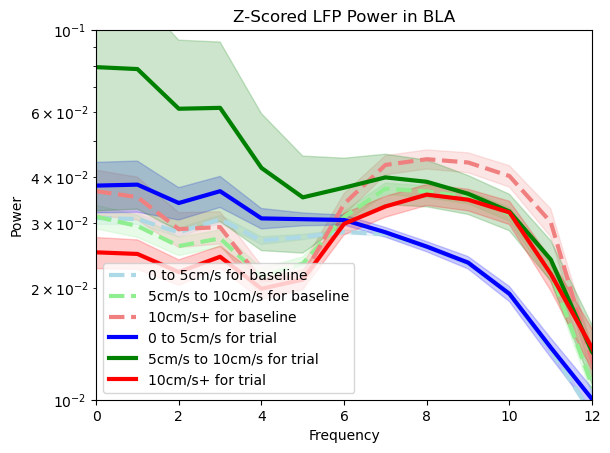

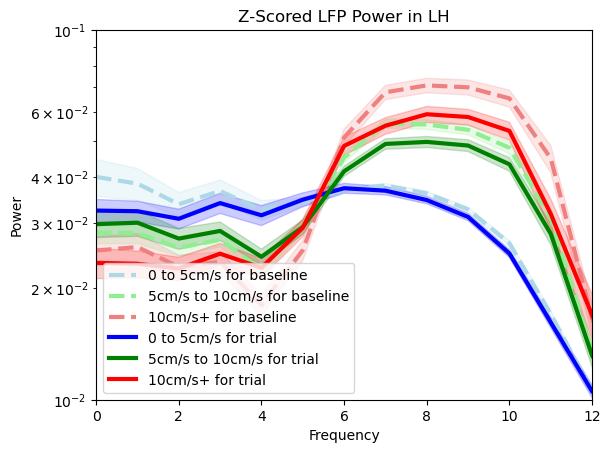

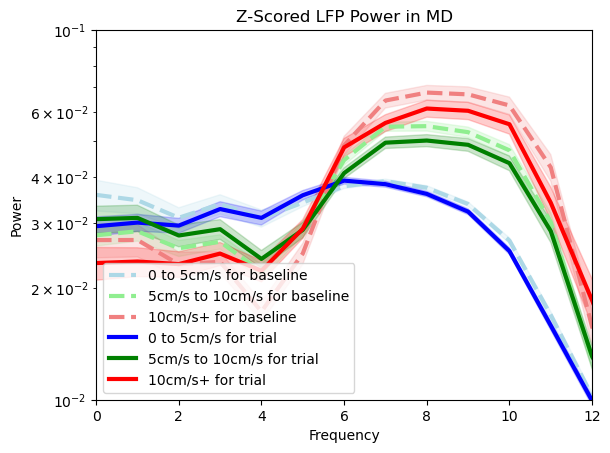

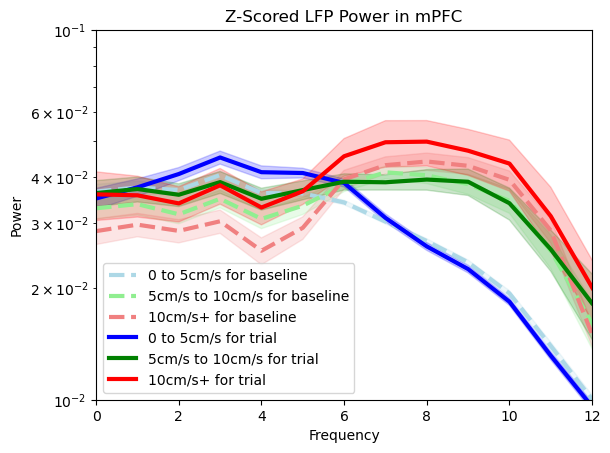

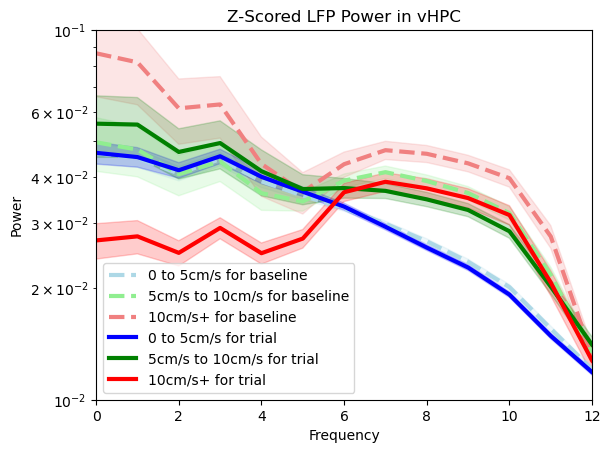

In [77]:
low_freq = 0
high_freq = 12
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]

    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {}".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.01, 0.1)

    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} for {}".format(BIN_TO_VELOCITY[row["binned_current_thorax_velocity"]], \
            row["trial_or_baseline"]), color=BIN_TO_COLOR[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]],
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)

            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], \
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2,
            color=BIN_TO_COLOR[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]])
        except Exception as e: 
            print(e)
            continue

    plt.legend(loc="lower left")
    
    plt.savefig("./proc/velocity_parsing/plot_region_line_velocity_baselinetrial/\
    rce_lfp_power_velocity_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))


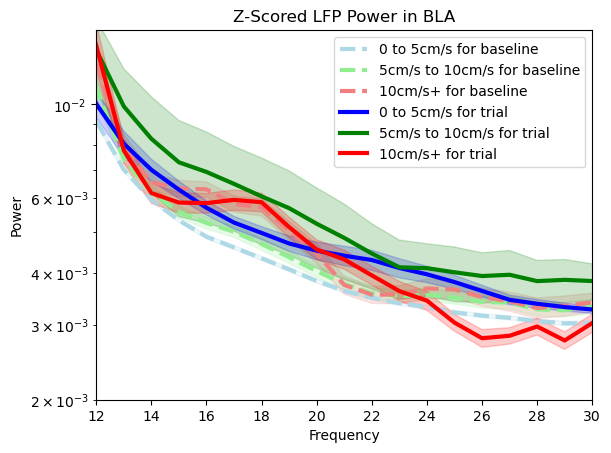

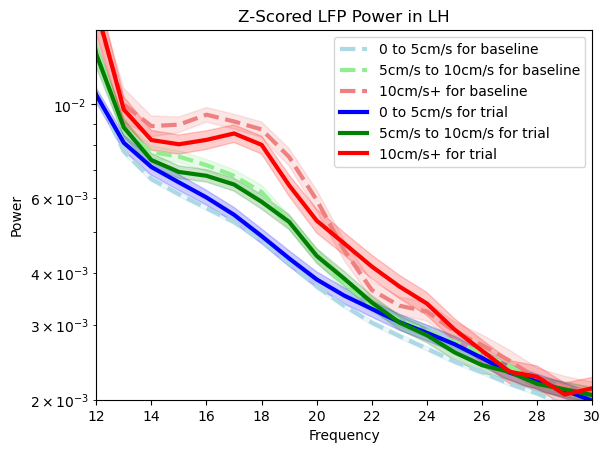

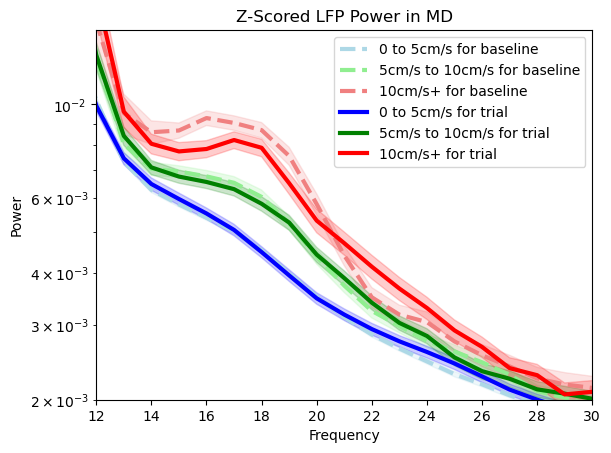

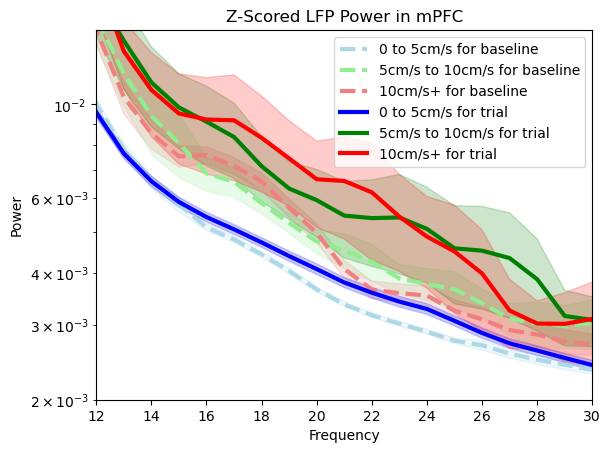

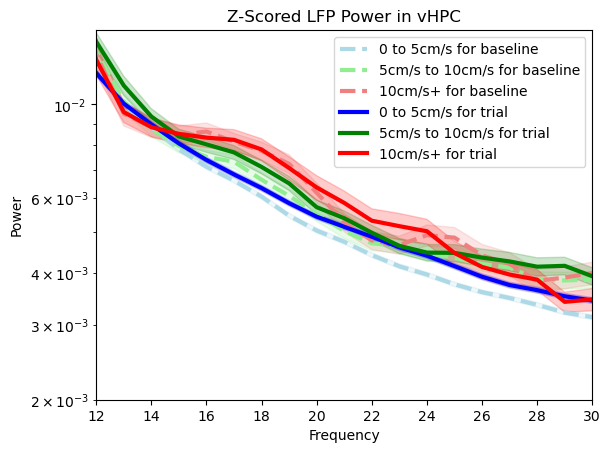

In [78]:
low_freq = 12
high_freq = 30
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]

    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {}".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.002, 0.015) 

    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} for {}".format(BIN_TO_VELOCITY[row["binned_current_thorax_velocity"]], \
            row["trial_or_baseline"]), color=BIN_TO_COLOR[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]],
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)

            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], \
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2,
            color=BIN_TO_COLOR[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]])
        except Exception as e: 
            print(e)
            continue

    plt.savefig("./proc/velocity_parsing/plot_region_line_velocity_baselinetrial/\
    rce_lfp_power_velocity_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))


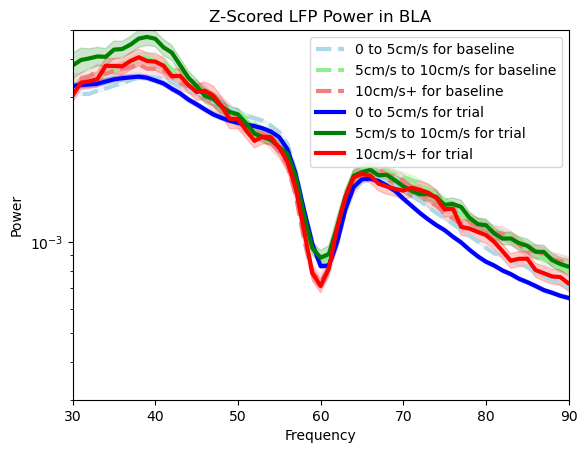

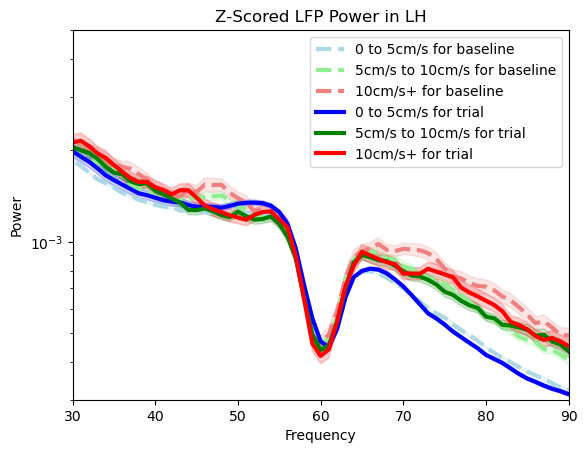

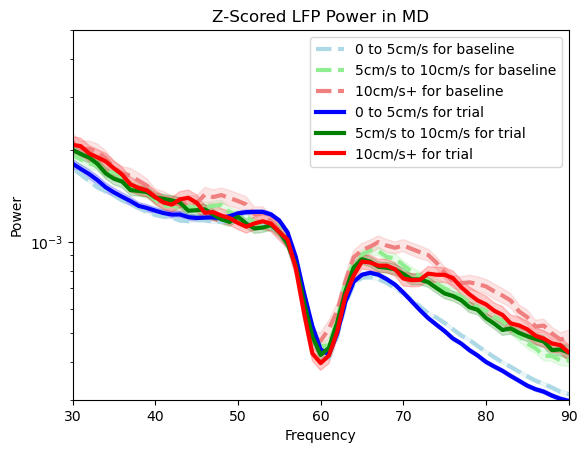

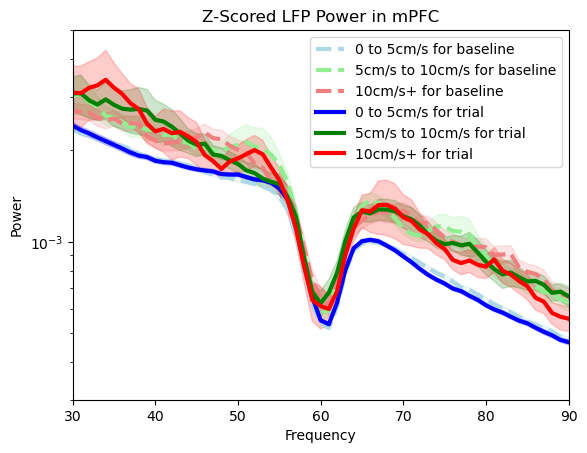

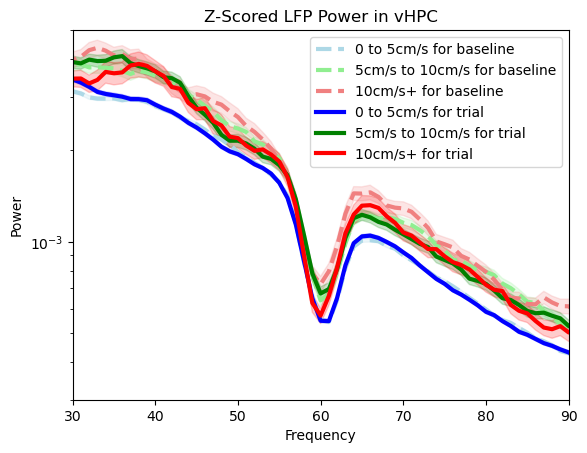

In [79]:
low_freq = 30
high_freq = 90
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]

    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {}".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    # plt.ylim(0, 0.005)
    plt.yscale("log")
    plt.ylim(0.0003, 0.005) 

    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} for {}".format(BIN_TO_VELOCITY[row["binned_current_thorax_velocity"]], \
            row["trial_or_baseline"]), color=BIN_TO_COLOR[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]],
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)

            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], \
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2,
            color=BIN_TO_COLOR[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]])
        except Exception as e: 
            print(e)
            continue
    plt.legend()
    plt.savefig("./proc/velocity_parsing/plot_region_line_velocity_baselinetrial/\
    rce_lfp_power_velocity_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))


## Plotting all the lower velocities together

In [80]:
speed_filtered_all_trials_df = exploded_channel_map_and_all_trials_df[exploded_channel_map_and_all_trials_df["binned_current_thorax_velocity"] == 0]

In [81]:
speed_filtered_all_trials_df.shape

(21035, 79)

In [82]:
grouped_all_trials_df = speed_filtered_all_trials_df.groupby(['brain_region', 'trial_outcome', 'trial_or_baseline']).agg({'power': lambda x: np.vstack(x.tolist())}).reset_index()

In [83]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [84]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [85]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [86]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

In [87]:
grouped_all_trials_df["trial_outcome"].unique()

array(['lose', 'omission', 'rewarded', 'win'], dtype=object)

# Drawing plots all together

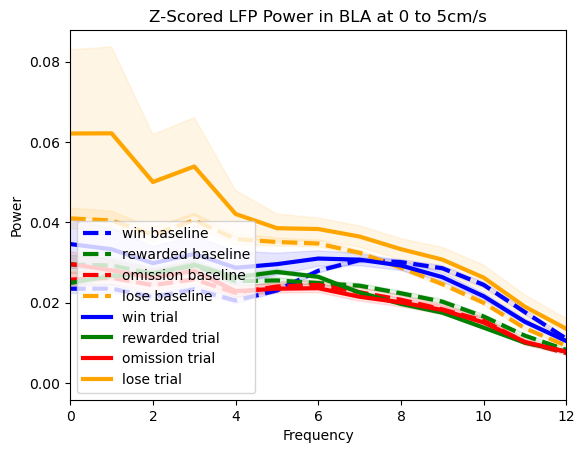

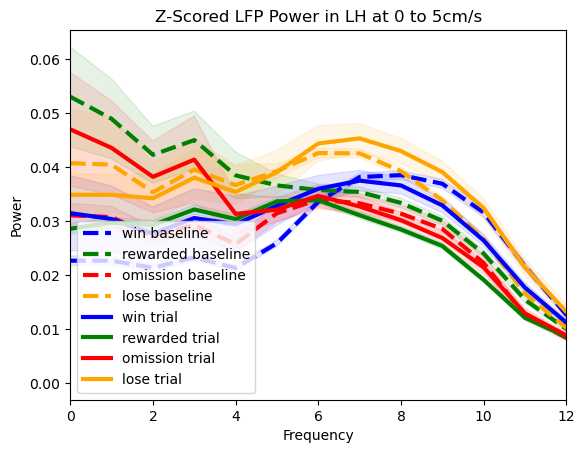

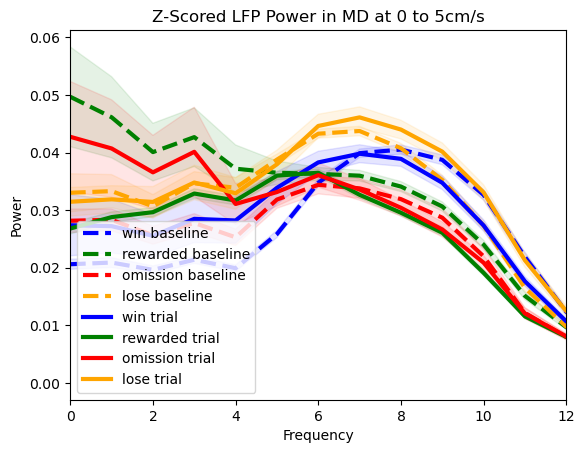

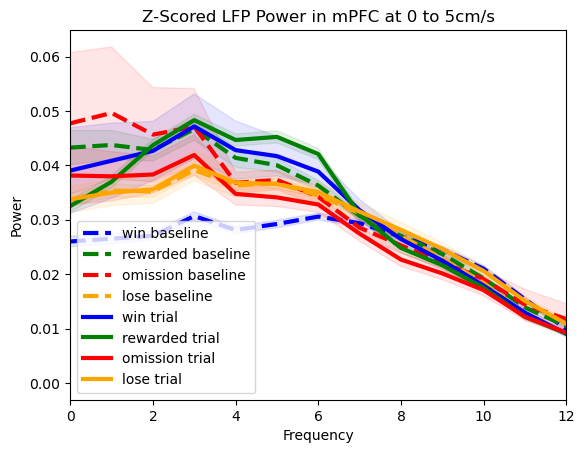

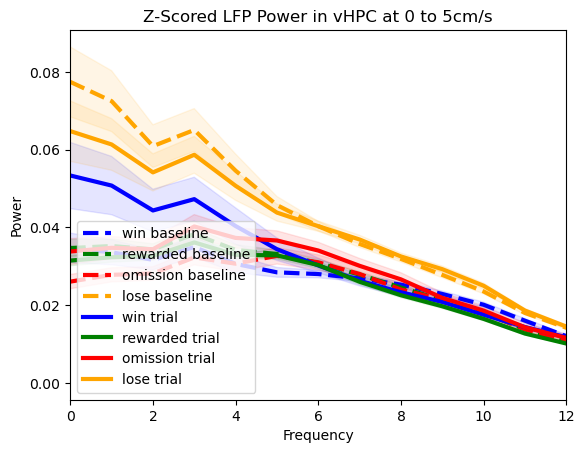

In [88]:
low_freq = 0
high_freq = 12
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 0 to 5cm/s".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq) 
    # plt.yscale("log")
    # plt.ylim(0.01, 0.06)

    for trial_or_baseline, outcome in itertools.product(region_df["trial_or_baseline"].unique(), sorted(region_df["trial_outcome"].unique())[::-1]):
        outcome_df = region_df[(region_df["trial_or_baseline"] == trial_or_baseline) & (region_df["trial_outcome"] == outcome)]
        for index, row in outcome_df.iterrows():
            try:
                ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
                label="{} {}".format(outcome, trial_or_baseline), color=BASELINE_OUTCOME_TO_COLOR[outcome], \
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                
                plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
                row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
                alpha=0.1, color=BASELINE_OUTCOME_TO_COLOR[outcome])
            
            except Exception as e: 
                print(e)
                continue
    plt.legend(loc="lower left")
    plt.savefig("./proc/velocity_parsing/plot_region_line_trialoutcome_baselinetrial/\
    rce_lower_velocity_lfp_power_trialoutcome_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))

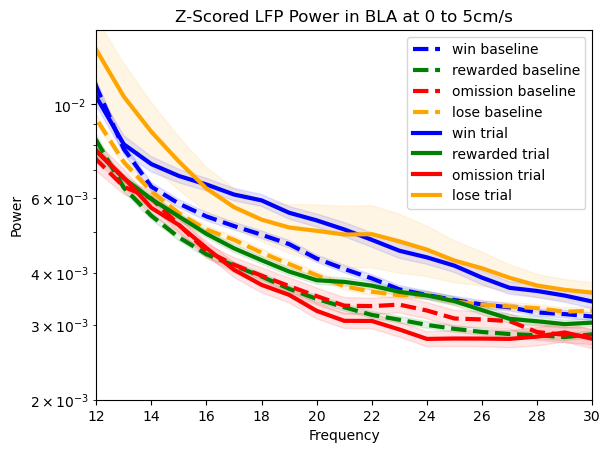

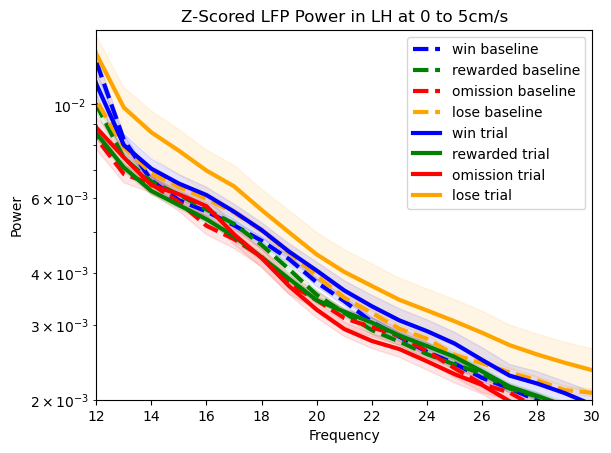

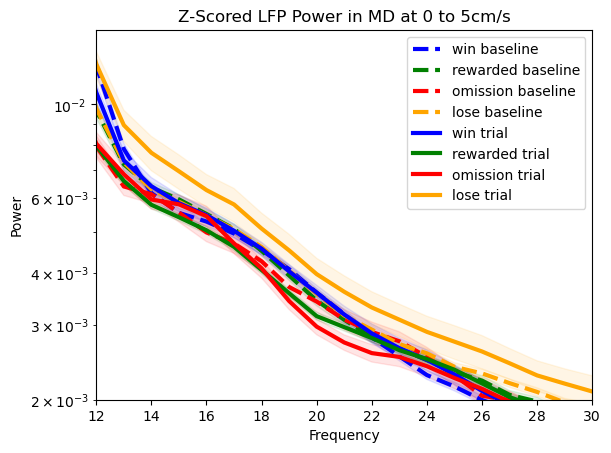

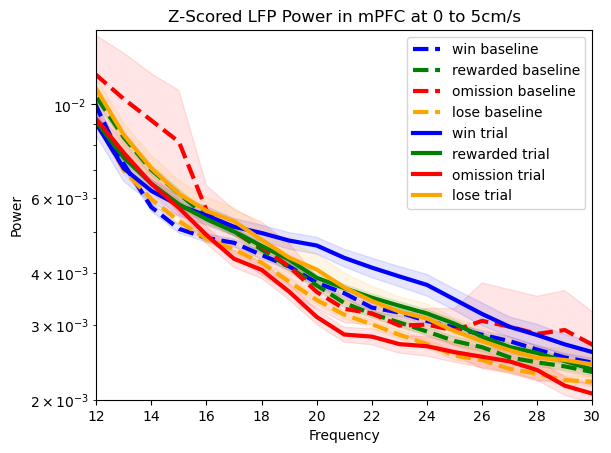

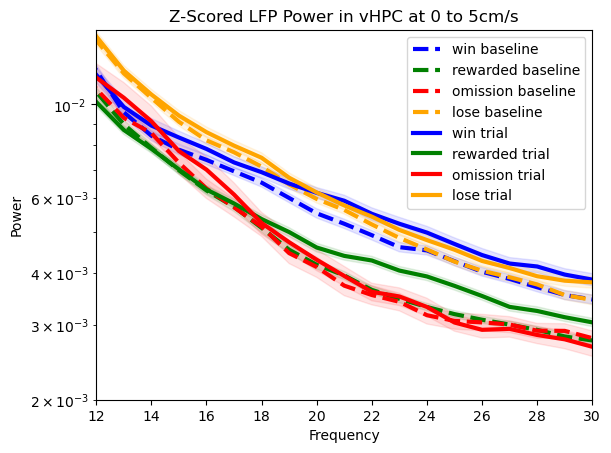

In [89]:
low_freq = 12
high_freq = 30
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 0 to 5cm/s".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.002, 0.015) 
    
    for trial_or_baseline, outcome in itertools.product(region_df["trial_or_baseline"].unique(), sorted(region_df["trial_outcome"].unique())[::-1]):
        outcome_df = region_df[(region_df["trial_or_baseline"] == trial_or_baseline) & (region_df["trial_outcome"] == outcome)]
        for index, row in outcome_df.iterrows():
            try:
                ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
                label="{} {}".format(outcome, trial_or_baseline), color=BASELINE_OUTCOME_TO_COLOR[outcome], \
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                
                plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
                row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
                alpha=0.1, color=BASELINE_OUTCOME_TO_COLOR[outcome])
            
            except Exception as e: 
                print(e)
                continue
    plt.legend(loc="upper right")
    plt.savefig("./proc/velocity_parsing/plot_region_line_trialoutcome_baselinetrial/\
    rce_lower_velocity_lfp_power_trialoutcome_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))

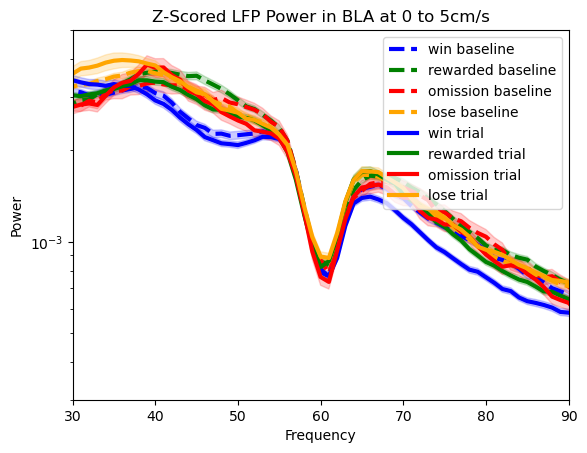

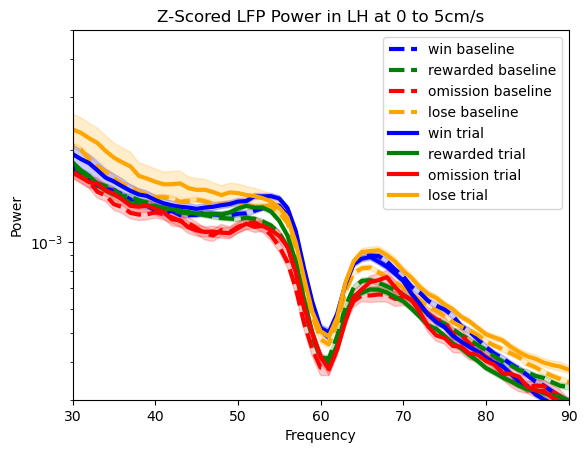

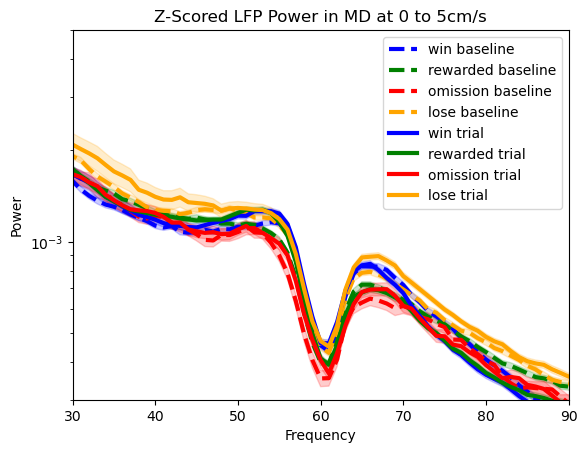

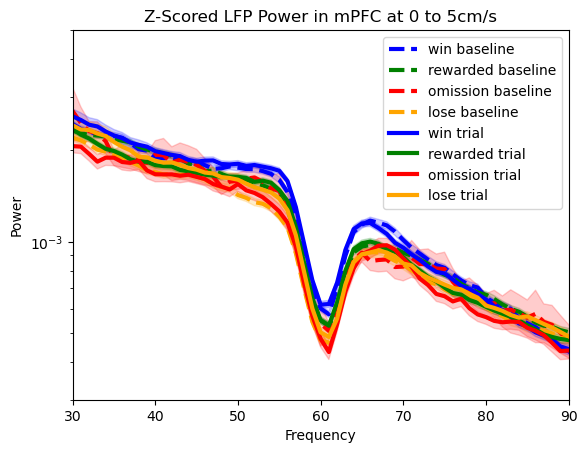

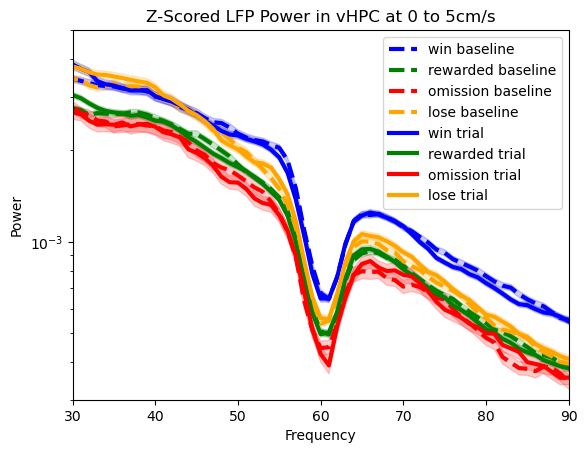

In [90]:
low_freq = 30
high_freq = 90
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 0 to 5cm/s".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.0003, 0.005) 
    
    for trial_or_baseline, outcome in itertools.product(region_df["trial_or_baseline"].unique(), sorted(region_df["trial_outcome"].unique())[::-1]):
        outcome_df = region_df[(region_df["trial_or_baseline"] == trial_or_baseline) & (region_df["trial_outcome"] == outcome)]
        for index, row in outcome_df.iterrows():
            try:
                ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
                label="{} {}".format(outcome, trial_or_baseline), color=BASELINE_OUTCOME_TO_COLOR[outcome], \
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                
                plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
                row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
                alpha=0.2, color=BASELINE_OUTCOME_TO_COLOR[outcome])
            
            except Exception as e: 
                print(e)
                continue
    plt.legend(loc="upper right")
    plt.savefig("./proc/velocity_parsing/plot_region_line_trialoutcome_baselinetrial/\
    rce_lower_velocity_lfp_power_trialoutcome_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))

# Exporting that data

In [91]:
speed_filtered_all_trials_df = exploded_channel_map_and_all_trials_df[exploded_channel_map_and_all_trials_df["binned_current_thorax_velocity"] == 0].copy()

In [92]:
speed_filtered_all_trials_df = speed_filtered_all_trials_df[~speed_filtered_all_trials_df["competition_closeness"].isin(['lose_non_comp', 'win_non_comp'])]

In [93]:
speed_filtered_all_trials_df["brain_region"]

1       spike_interface_mPFC
1       spike_interface_mPFC
1       spike_interface_mPFC
1       spike_interface_mPFC
1       spike_interface_mPFC
                ...         
4799      spike_interface_MD
4799      spike_interface_MD
4799      spike_interface_MD
4799      spike_interface_MD
4799      spike_interface_MD
Name: brain_region, Length: 16540, dtype: object

In [94]:
KEEP_COLUMNS = ['recording_file', 
       'time_stamp_index', 'competition_closeness', 'all_subjects', 'current_subject', 'trial_outcome',
       
       'trial_or_baseline',
       'current_chunked_thorax_velocity', 'chunked_lfp_index',
       'chunked_ephys_timestamp', 'binned_current_thorax_velocity', 'Cohort',
       'Subject',  'brain_region', 'channel',
       'chunk_id',
       'frequencies', 'power']

In [95]:
speed_filtered_all_trials_df = speed_filtered_all_trials_df[KEEP_COLUMNS].reset_index()

In [96]:
speed_filtered_all_trials_df["all_theta_power"] = speed_filtered_all_trials_df["power"].apply(lambda x: x[4:13])
speed_filtered_all_trials_df["all_beta_power"] = speed_filtered_all_trials_df["power"].apply(lambda x: x[13:30])
speed_filtered_all_trials_df["all_gamma_power"] = speed_filtered_all_trials_df["power"].apply(lambda x: x[30:90])
speed_filtered_all_trials_df["mean_theta_power"] = speed_filtered_all_trials_df["all_theta_power"].apply(lambda x: x.mean())
speed_filtered_all_trials_df["mean_beta_power"] = speed_filtered_all_trials_df["all_beta_power"].apply(lambda x: x.mean())
speed_filtered_all_trials_df["mean_gamma_power"] = speed_filtered_all_trials_df["all_gamma_power"].apply(lambda x: x.mean())

In [97]:
speed_filtered_all_trials_df.head()

index                                     recording_file  time_stamp_index  \
0      1  20230617_115521_standard_comp_to_omission_D1_s...         1030879.0   
1      1  20230617_115521_standard_comp_to_omission_D1_s...         1030879.0   
2      1  20230617_115521_standard_comp_to_omission_D1_s...         1030879.0   
3      1  20230617_115521_standard_comp_to_omission_D1_s...         1030879.0   
4      1  20230617_115521_standard_comp_to_omission_D1_s...         1030879.0   

  competition_closeness all_subjects current_subject trial_outcome  \
0             lose_comp   [1.1, 1.2]             1.1          lose   
1             lose_comp   [1.1, 1.2]             1.1          lose   
2             lose_comp   [1.1, 1.2]             1.1          lose   
3             lose_comp   [1.1, 1.2]             1.1          lose   
4             lose_comp   [1.1, 1.2]             1.1          lose   

  trial_or_baseline current_chunked_thorax_velocity   chunked_lfp_index  ...  \
0          baseline                        1.048204  (41543.0, 42543.0)  ...   
1          baseline                        0.317086  (42543.0, 43543.0)  ...   
2          baseline                        0.369759  (43543.0, 44543.0)  ...   
3          baseline                        1.053413  (44543.0, 45543.0)  ...   
4          baseline                        0.894525  (45543.0, 46543.0)  ...   

  channel chunk_id                                        frequencies  \
0       5        0  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
1       5        1  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
2       5        2  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
3       5        3  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
4       5        4  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   

                                               power  \
0  [0.13849083649217706, 0.12413016979887025, 0.1...   
1  [0.01437127936451168, 0.011455511174182078, 0....   
2  [0.01191138331412541, 0.018479671376279695, 0....   
3  [0.02542437000749434, 0.015909740675252033, 0....   
4  [0.013928834570356277, 0.022807935726024204, 0...   

                                     all_theta_power  \
0  [0.07886291167763411, 0.07429709480269214, 0.0...   
1  [0.07725148917390301, 0.10514773212228352, 0.0...   
2  [0.09016426567620762, 0.09362720699251424, 0.0...   
3  [0.04619176580311022, 0.039496289024681996, 0....   
4  [0.06018057292643058, 0.05929922819541951, 0.0...   

                                      all_beta_power  \
0  [0.005636225313701861, 0.005536219312475849, 0...   
1  [0.006543198350467423, 0.004967485773696111, 0...   
2  [0.017281918612643384, 0.010047512632848185, 0...   
3  [0.0077630462454602095, 0.005649237817310665, ...   
4  [0.014326936680092947, 0.013931735346629476, 0...   

                                     all_gamma_power mean_theta_power  \
0  [0.004131560507979027, 0.003729788183667926, 0...         0.043429   
1  [0.004218450579742787, 0.003314379247248317, 0...         0.051794   
2  [0.0038907183738339486, 0.0015006167225708905,...         0.048635   
3  [0.0014233660904194008, 0.0017771987285366447,...         0.033519   
4  [0.0019572394280466736, 0.002245923925013909, ...         0.043098   

  mean_beta_power mean_gamma_power  
0        0.003845         0.001019  
1        0.004711         0.000981  
2        0.006900         0.001062  
3        0.004207         0.001216  
4        0.005297         0.001153  

[5 rows x 25 columns]

In [98]:
speed_filtered_all_trials_df.to_pickle("./proc/rce_1_sec_interval_lfp_power_spectra_and_velocity.pkl")

In [99]:
raise ValueError()

ValueError: 

# Drawing a spectogram

In [100]:
# Sample dataframe
data = {
    'grouping_col': ['A', 'A', 'B', 'B'],
    'values_col': [[1, 2, 3], [4, 5, 6], [1, 2, 1], [3, 4, 5]]
}
df = pd.DataFrame(data)

def average_by_stacking(lists):
    # Stack the lists into a 2D array
    stacked = np.vstack(lists)
    # Compute the average for each column
    avg = np.median(stacked, axis=0)
    return avg.tolist()

result = df.groupby('grouping_col')['values_col'].apply(average_by_stacking).reset_index()
print(result)


  grouping_col       values_col
0            A  [2.5, 3.5, 4.5]
1            B  [2.0, 3.0, 3.0]


In [101]:
df

grouping_col values_col
0            A  [1, 2, 3]
1            A  [4, 5, 6]
2            B  [1, 2, 1]
3            B  [3, 4, 5]

In [102]:
from itertools import product

In [103]:
outcome_to_region_to_groupings = defaultdict(dict)
for trial_outcome, brain_region in product(speed_filtered_all_trials_df["trial_outcome"].unique(), speed_filtered_all_trials_df["brain_region"].unique()):
    print(trial_outcome, brain_region)
    trial_df = speed_filtered_all_trials_df[(speed_filtered_all_trials_df["trial_outcome"] == trial_outcome) & (speed_filtered_all_trials_df["brain_region"] == brain_region) & (speed_filtered_all_trials_df["trial_or_baseline"] == "trial")]
    trial_df = trial_df.groupby('chunk_id')['power'].apply(average_by_stacking).reset_index()

    baseline_df = speed_filtered_all_trials_df[(speed_filtered_all_trials_df["trial_outcome"] == trial_outcome) & (speed_filtered_all_trials_df["brain_region"] == brain_region) & (speed_filtered_all_trials_df["trial_or_baseline"] == "baseline")]
    baseline_df = baseline_df.groupby('chunk_id')['power'].apply(average_by_stacking).reset_index()
    baseline_df["chunk_id"] = baseline_df["chunk_id"] - 10
    
    grouped_df = pd.concat([baseline_df, trial_df])
    grouped_df["theta_power"] = grouped_df["power"].apply(lambda x: x[4:13])
    grouped_df["beta_power"] = grouped_df["power"].apply(lambda x: x[12:31])
    grouped_df["gamma_power"] = grouped_df["power"].apply(lambda x: x[30:90])
    grouped_df["power"] = grouped_df["power"].apply(lambda x: x[:90])



    
    outcome_to_region_to_groupings[brain_region][trial_outcome] = grouped_df

lose spike_interface_mPFC
lose spike_interface_vHPC
lose spike_interface_BLA
lose spike_interface_LH
lose spike_interface_MD
win spike_interface_mPFC
win spike_interface_vHPC
win spike_interface_BLA
win spike_interface_LH
win spike_interface_MD
rewarded spike_interface_mPFC
rewarded spike_interface_vHPC
rewarded spike_interface_BLA
rewarded spike_interface_LH
rewarded spike_interface_MD
omission spike_interface_mPFC
omission spike_interface_vHPC
omission spike_interface_BLA
omission spike_interface_LH
omission spike_interface_MD


In [104]:
grouped_df = outcome_to_region_to_groupings["spike_interface_LH"]["win"]

In [105]:
ALL_POWERS = ["theta_power", "beta_power", "gamma_power"]

In [106]:
import matplotlib.colors as colors

In [107]:
'Blues', 'Greens', 'Oranges', 'Reds'

('Blues', 'Greens', 'Oranges', 'Reds')

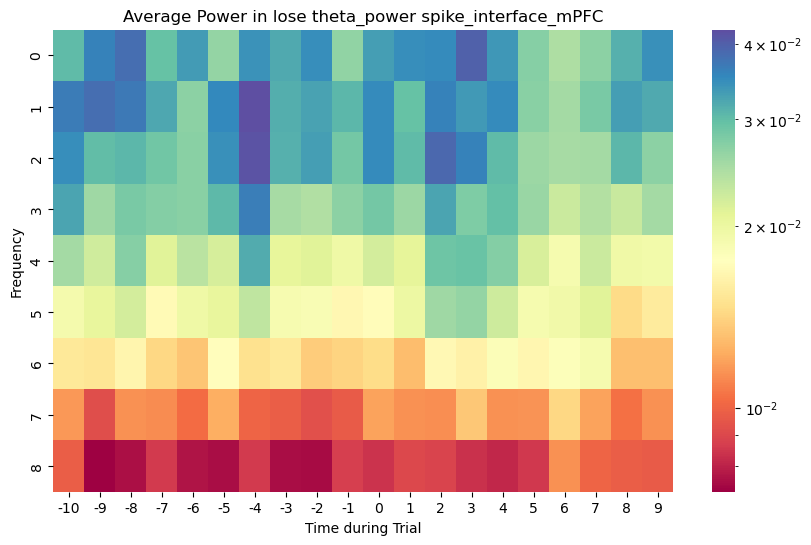

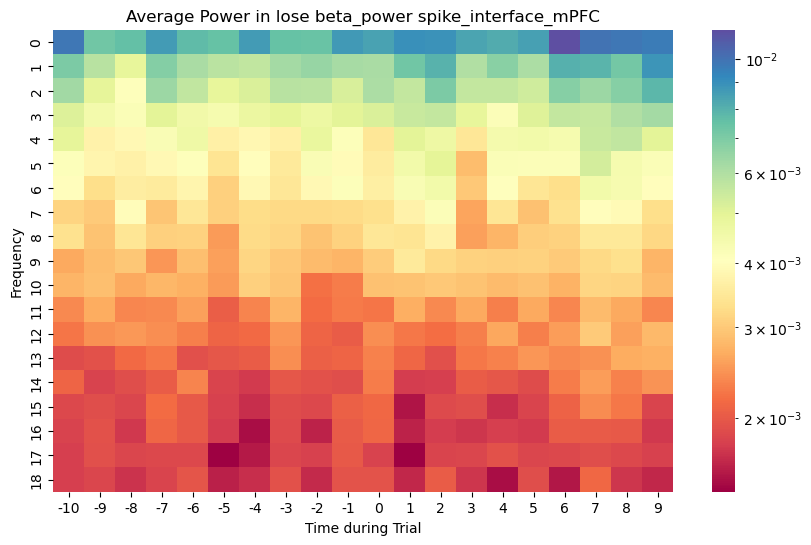

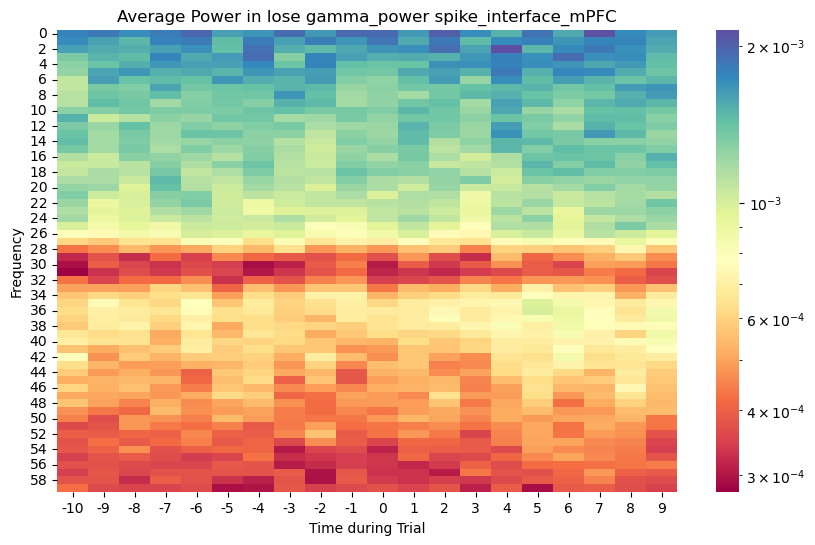

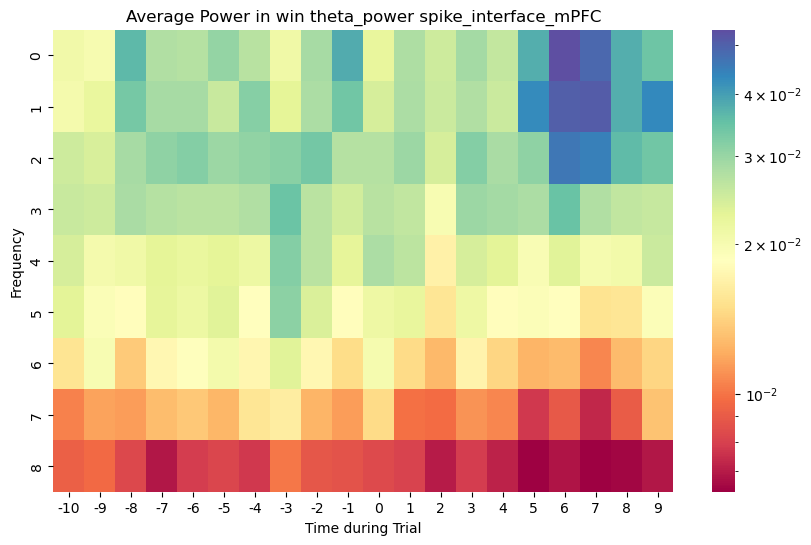

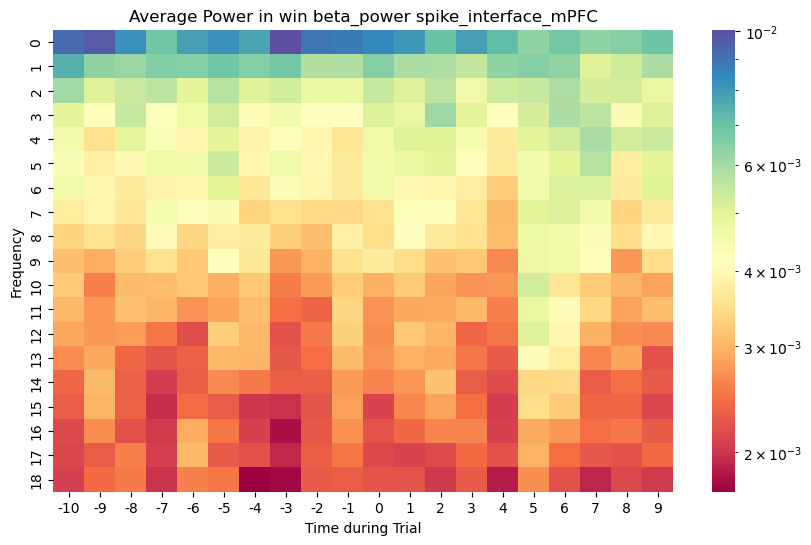

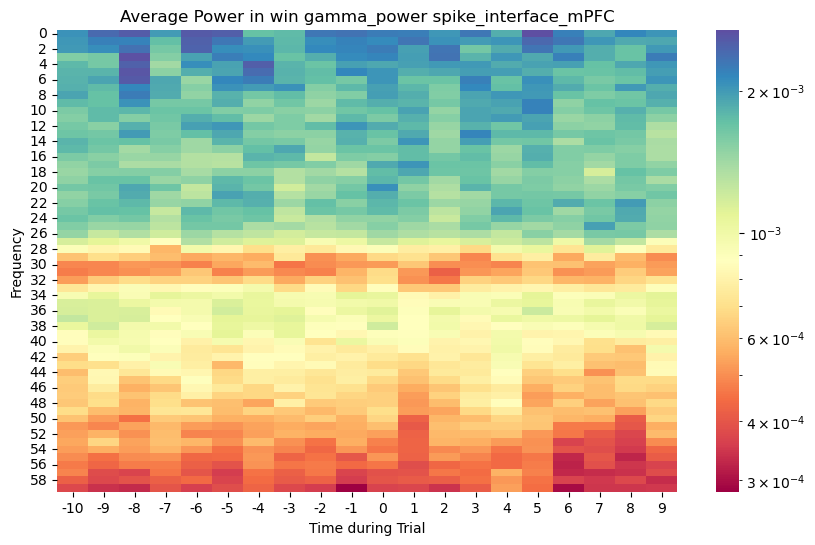

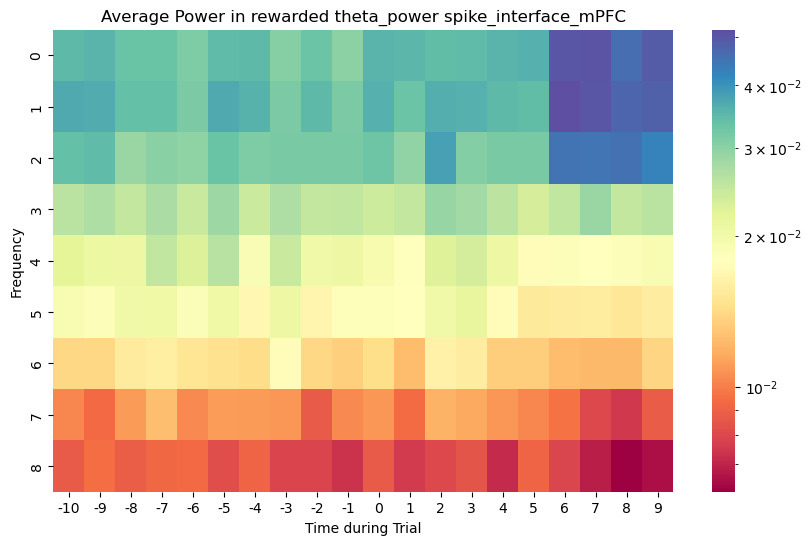

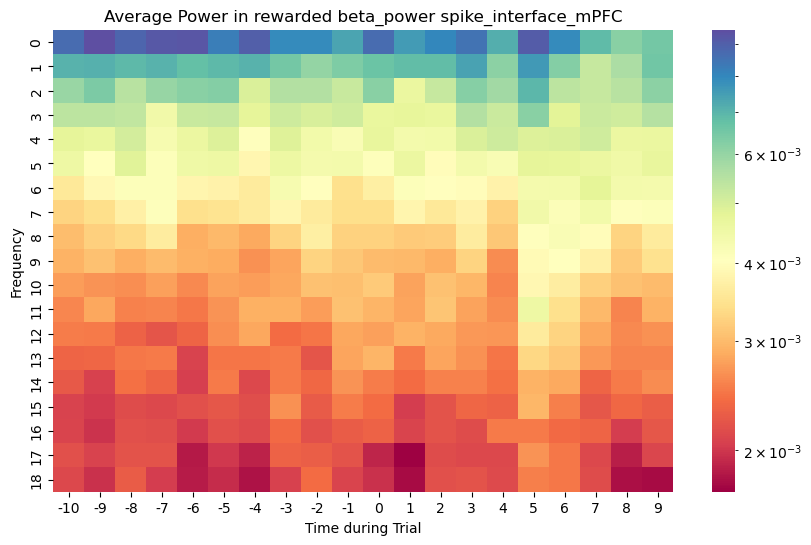

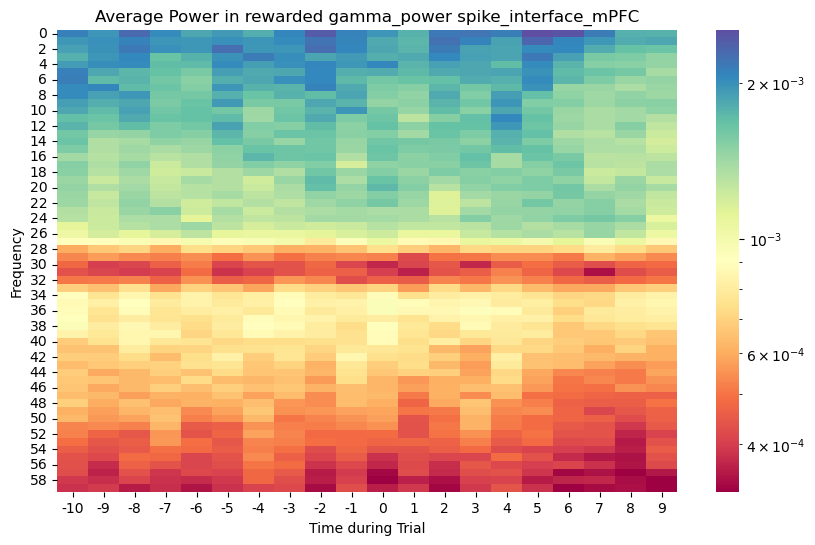

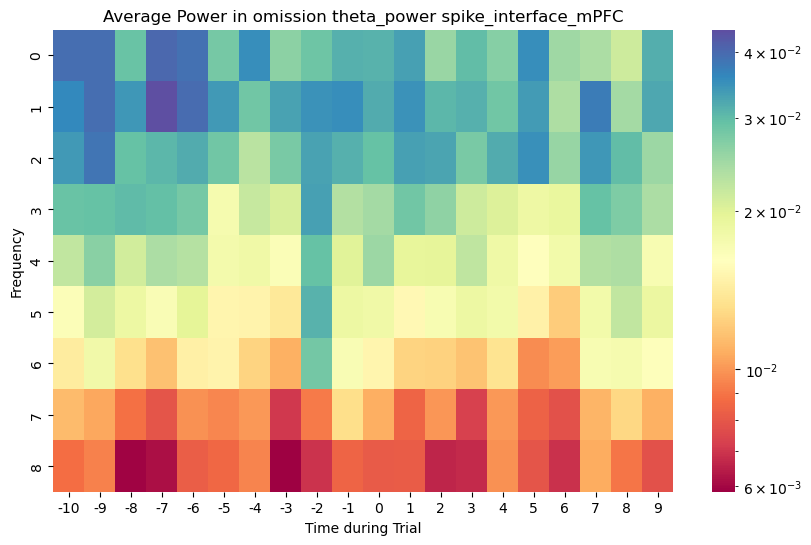

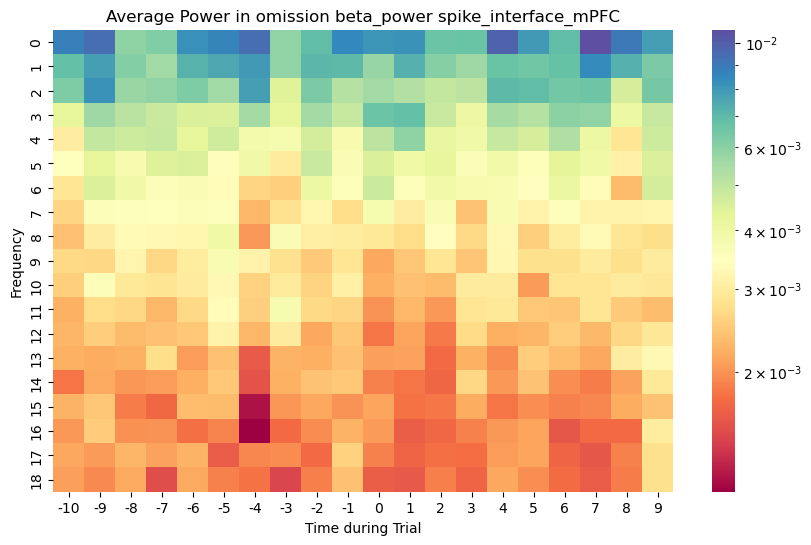

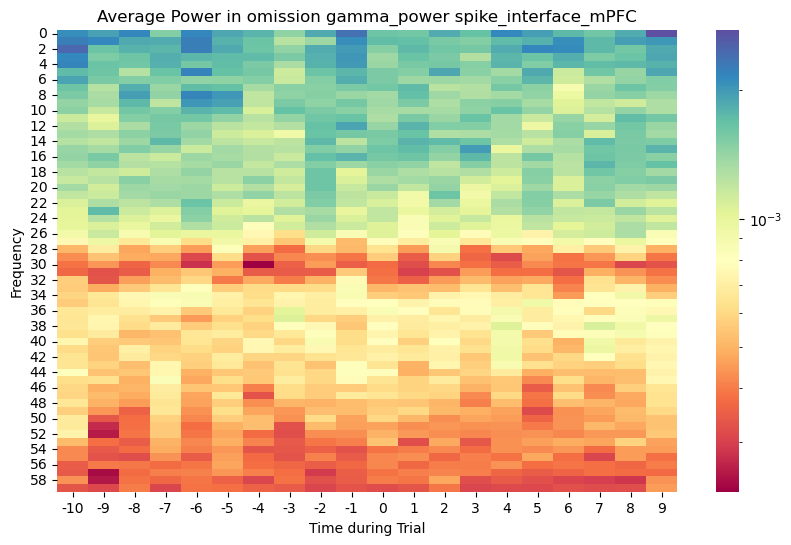

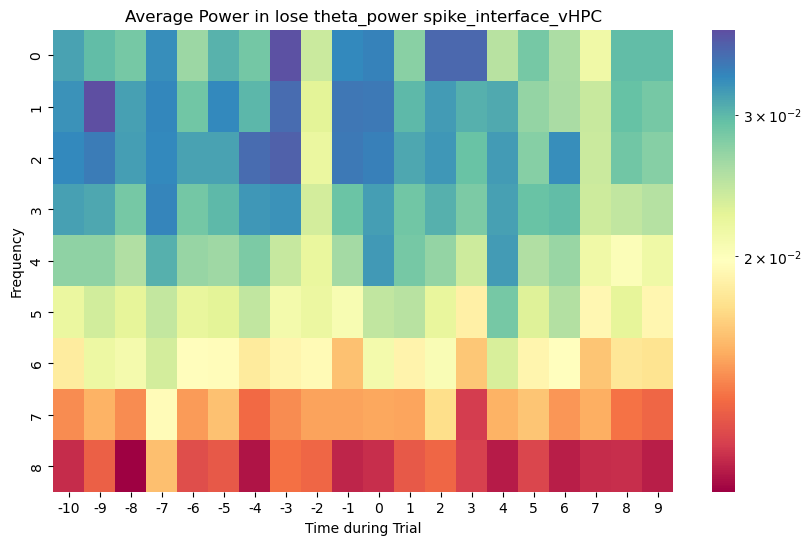

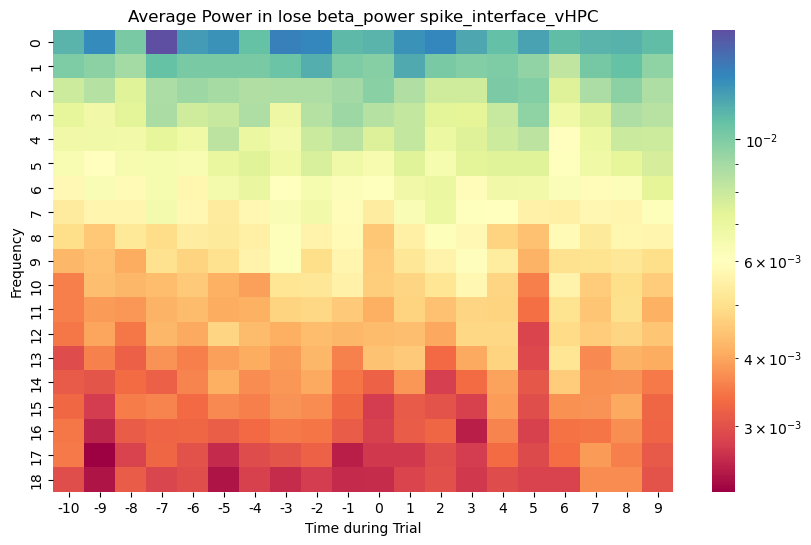

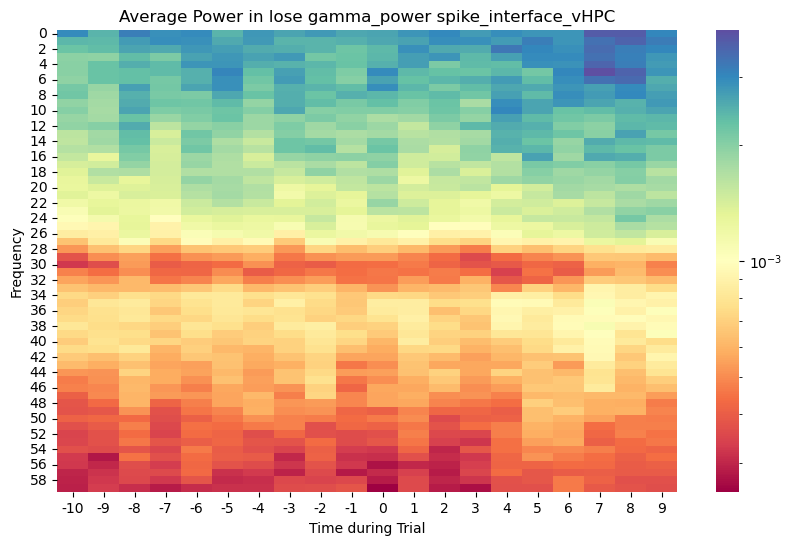

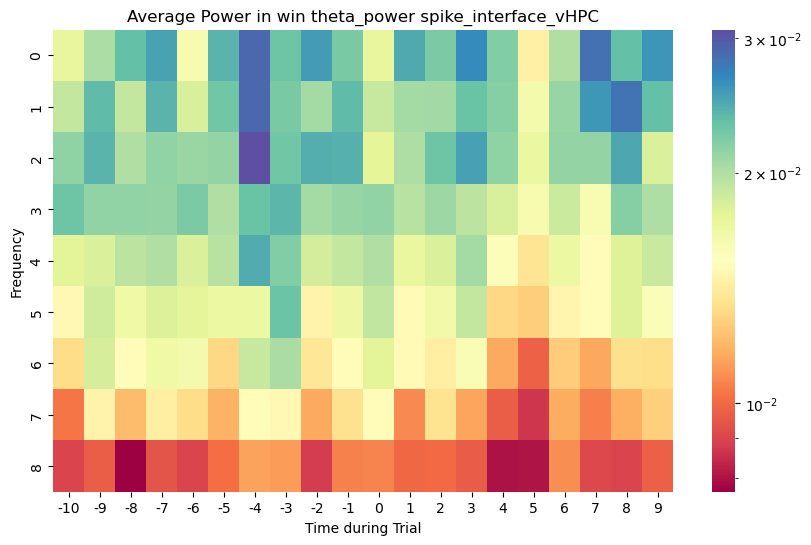

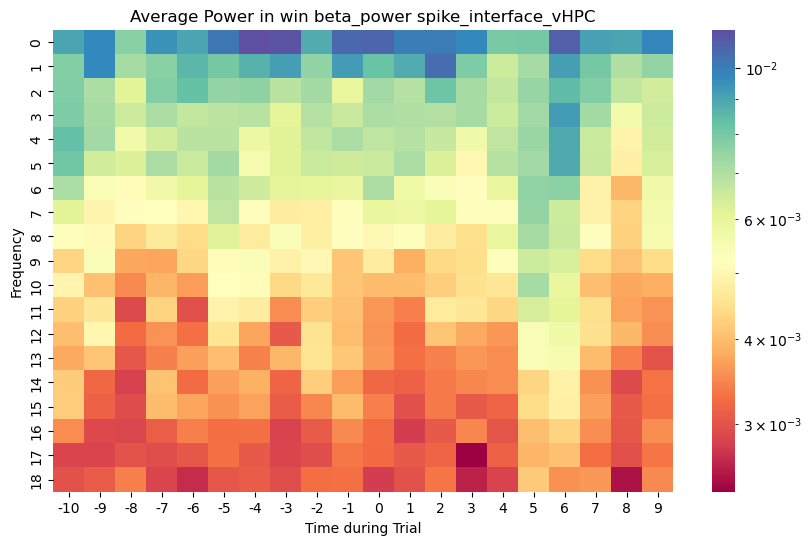

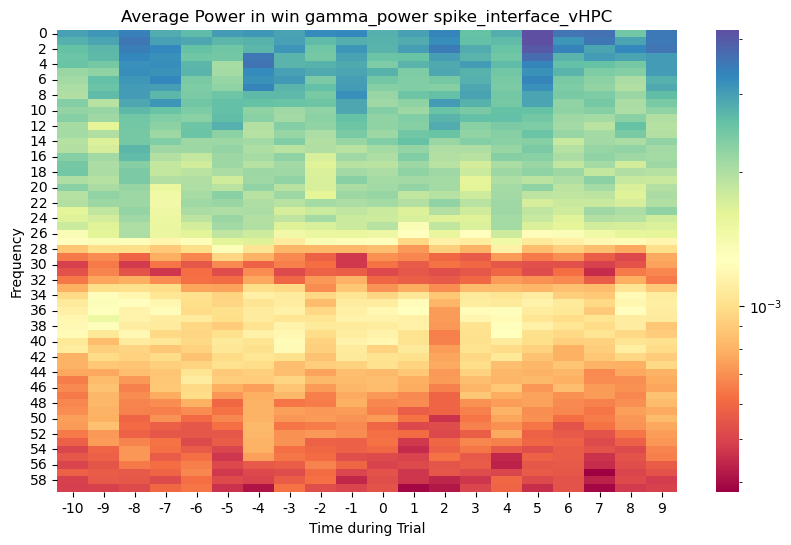

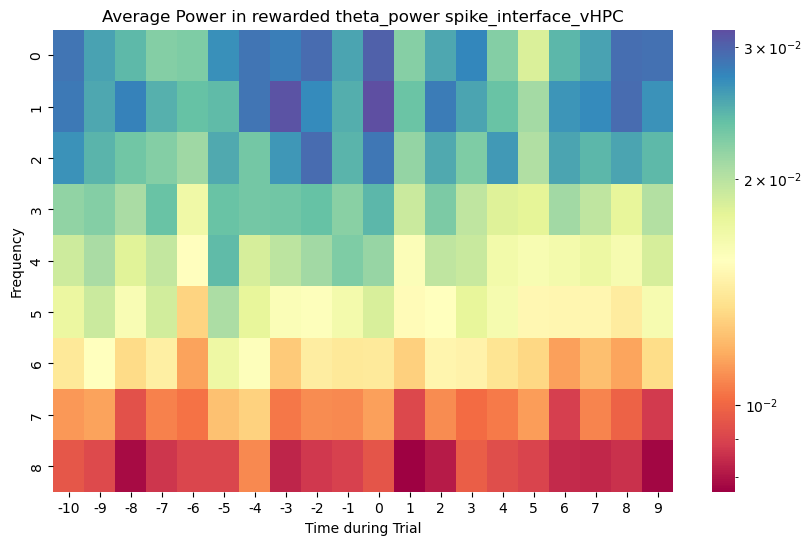

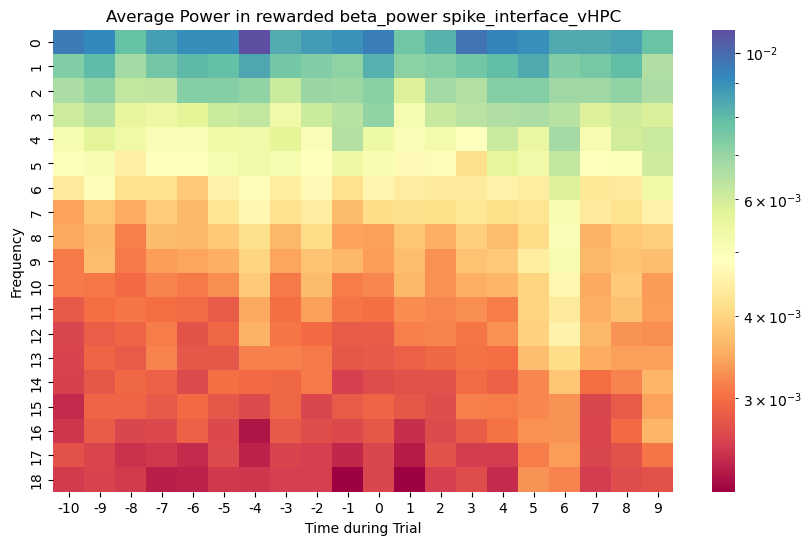

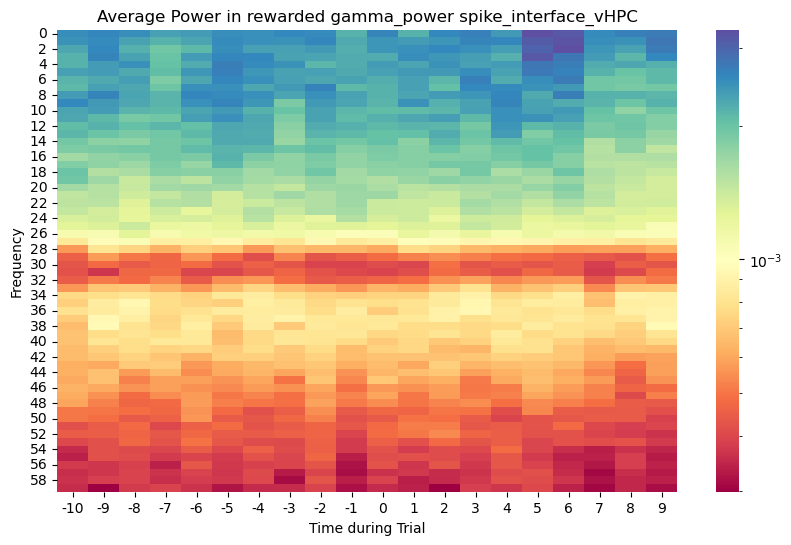

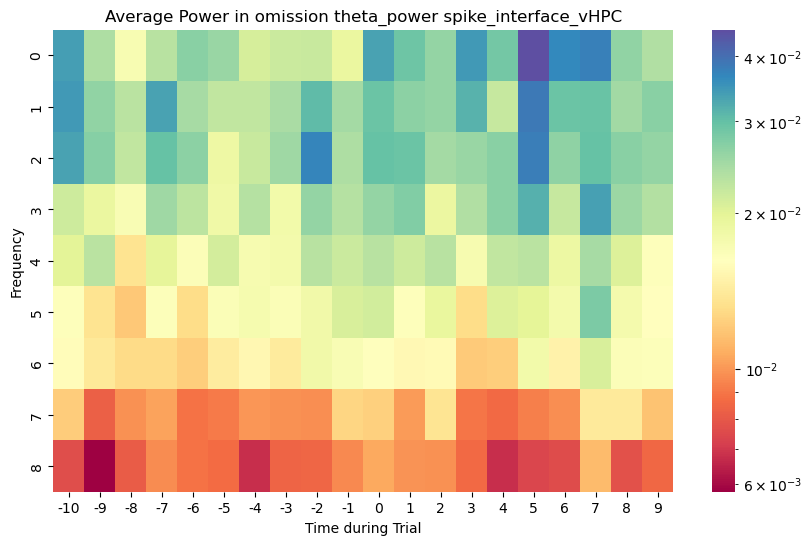

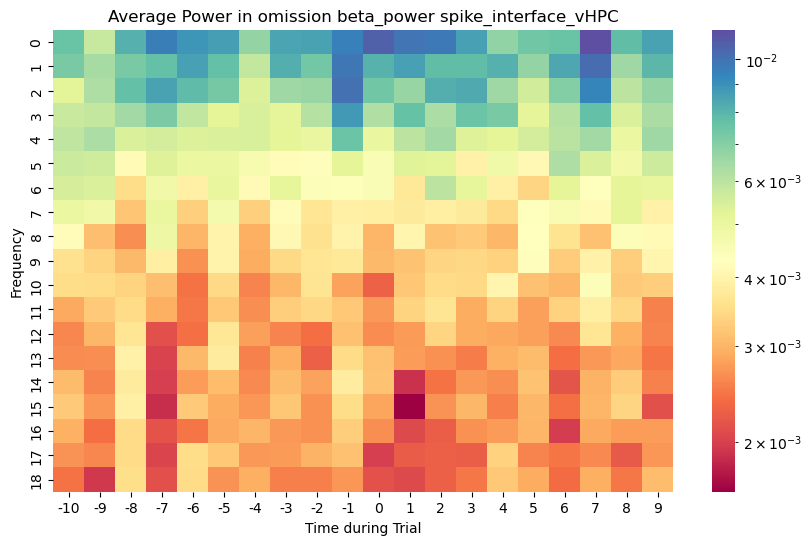

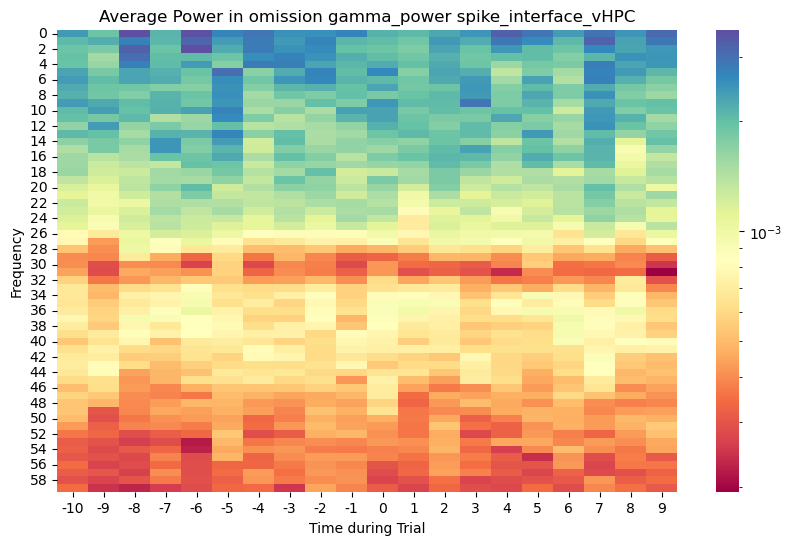

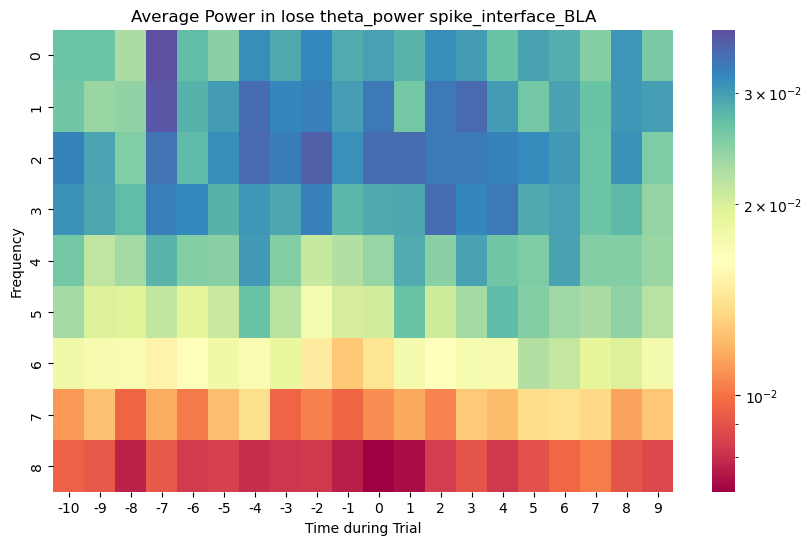

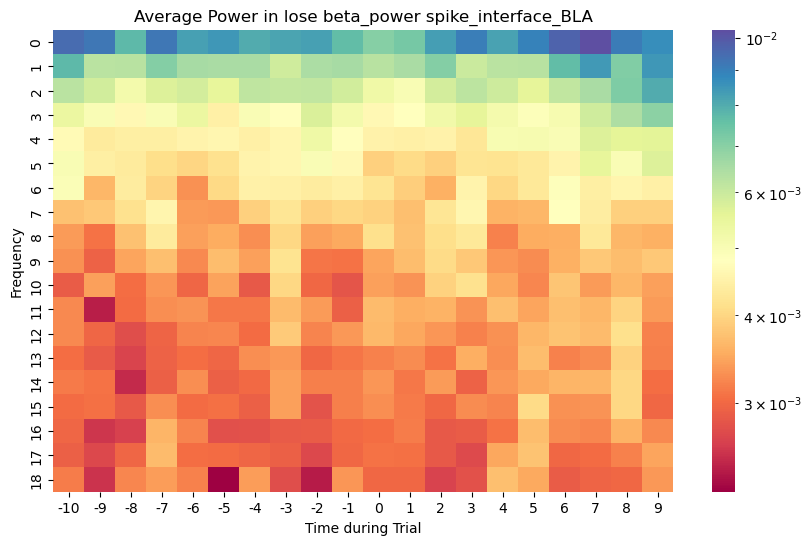

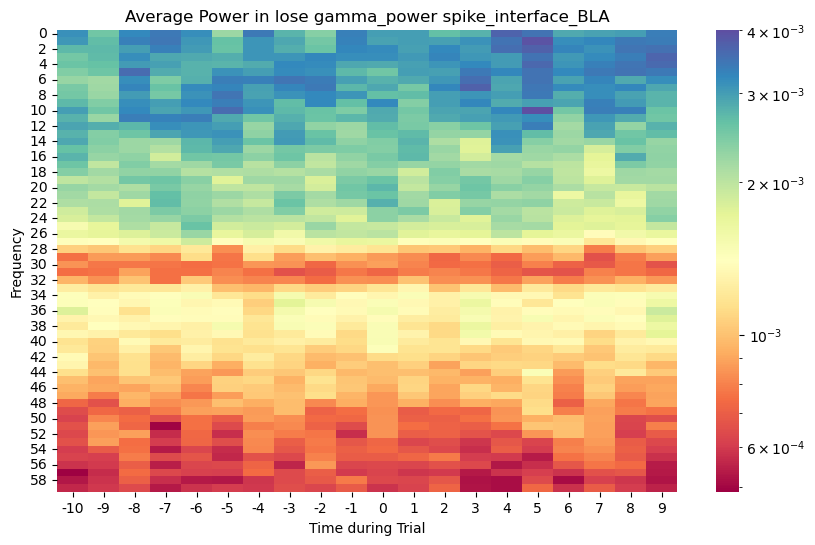

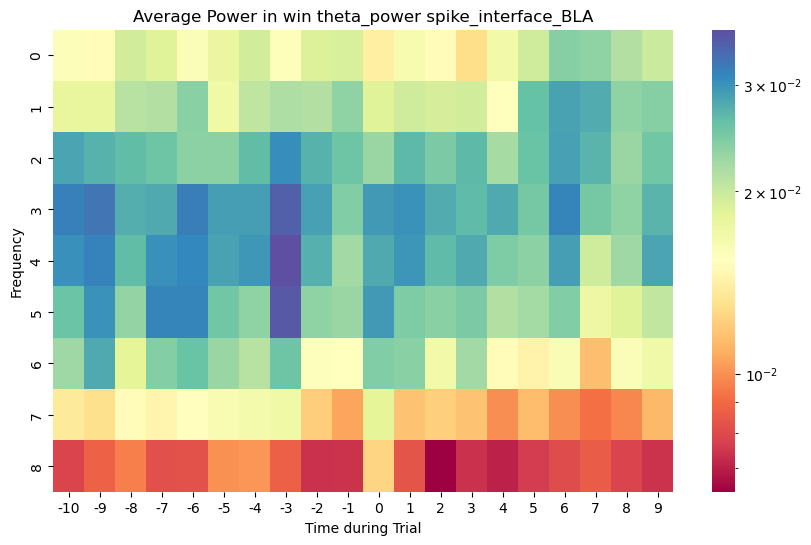

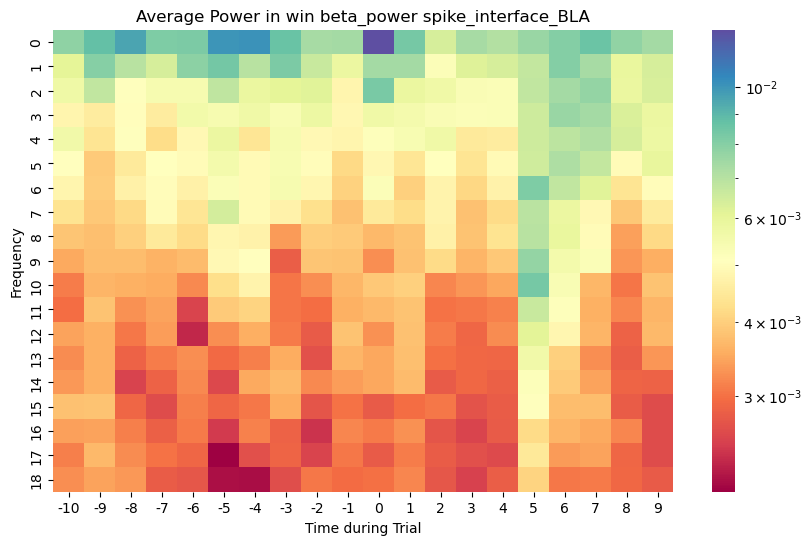

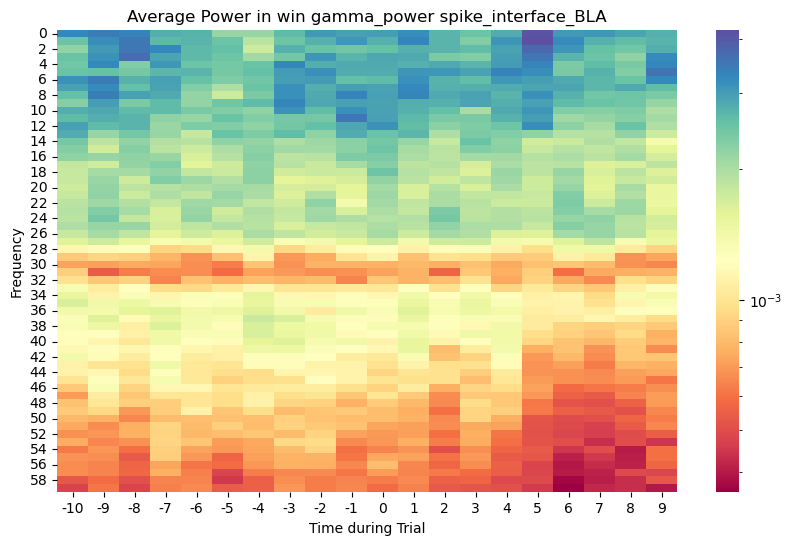

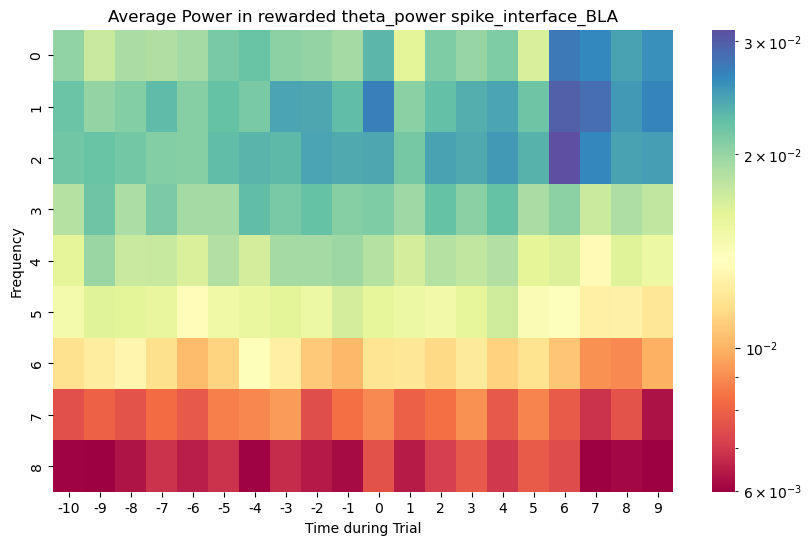

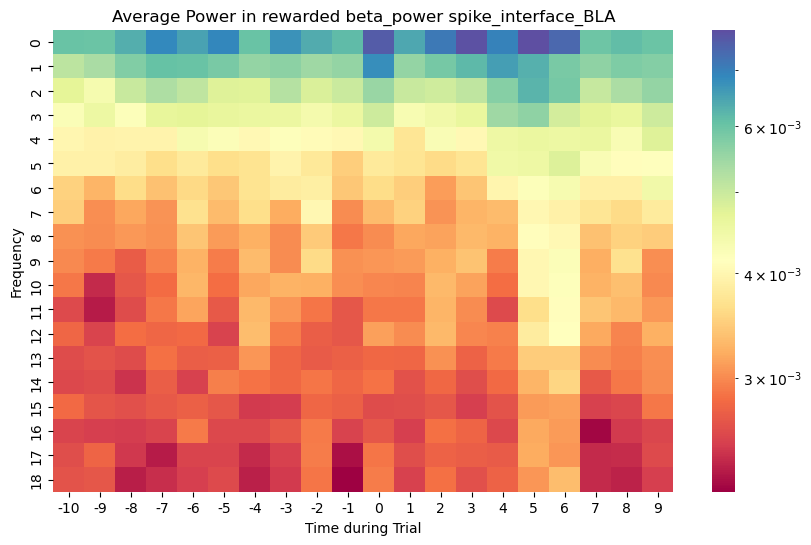

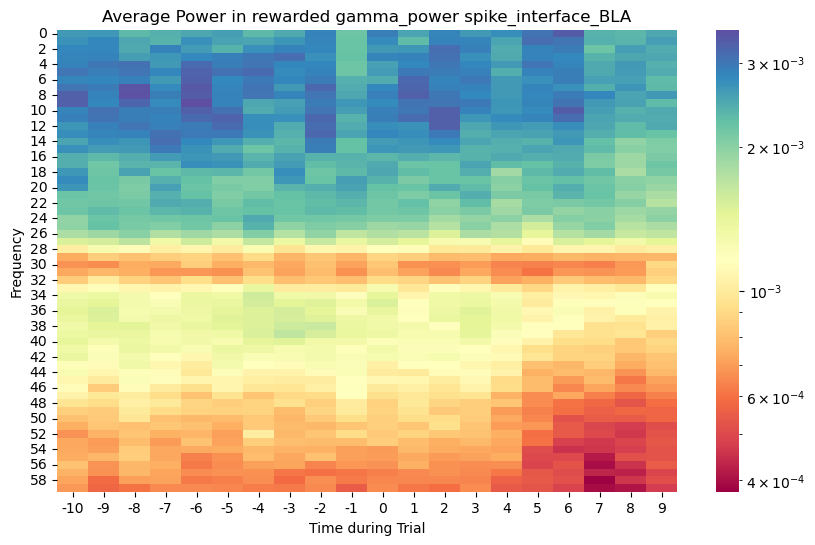

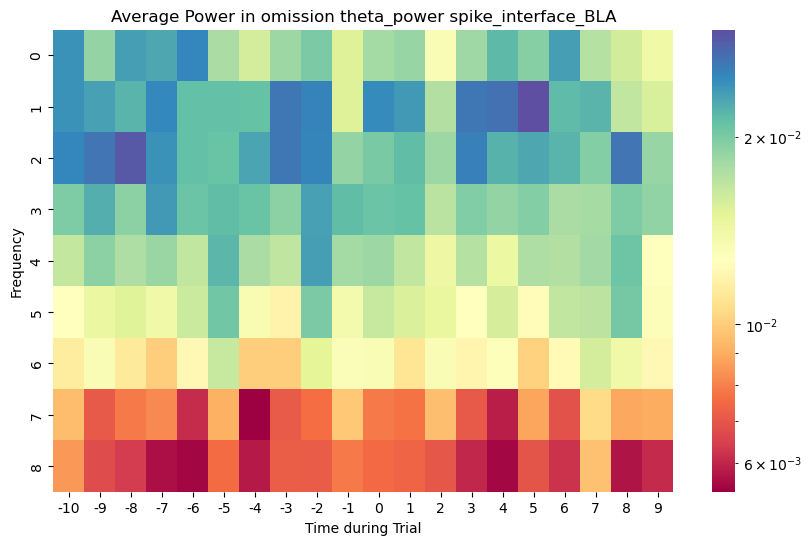

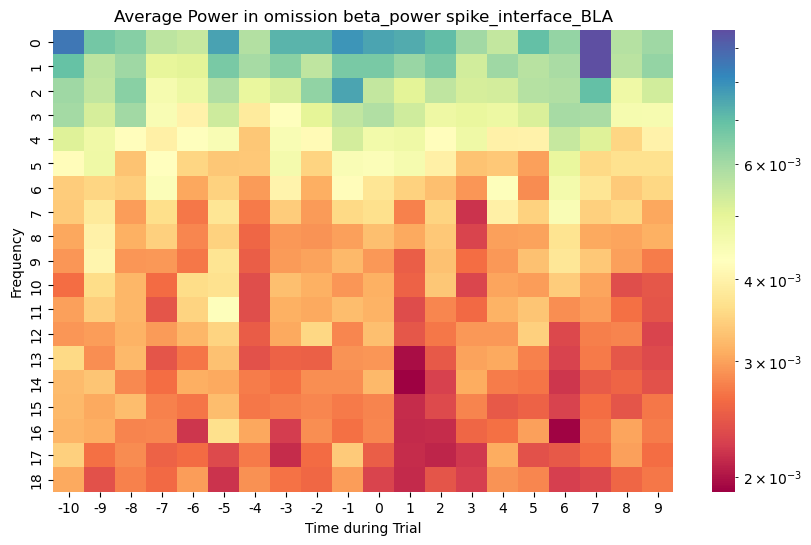

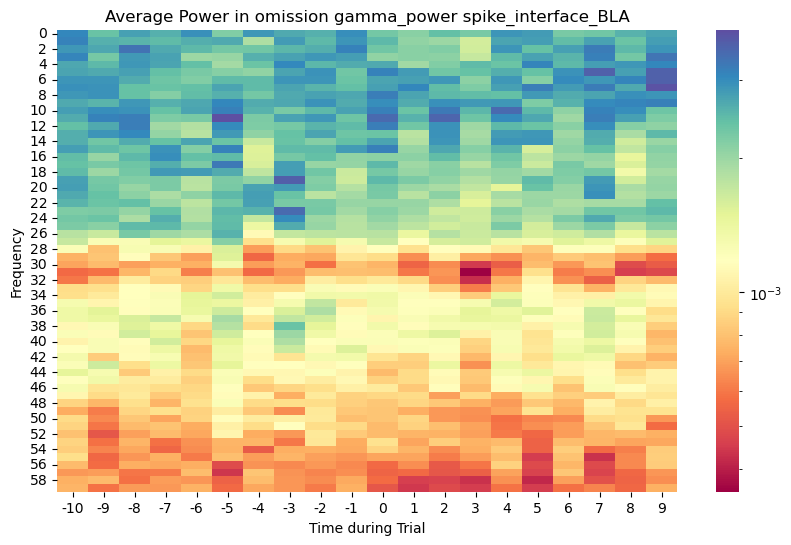

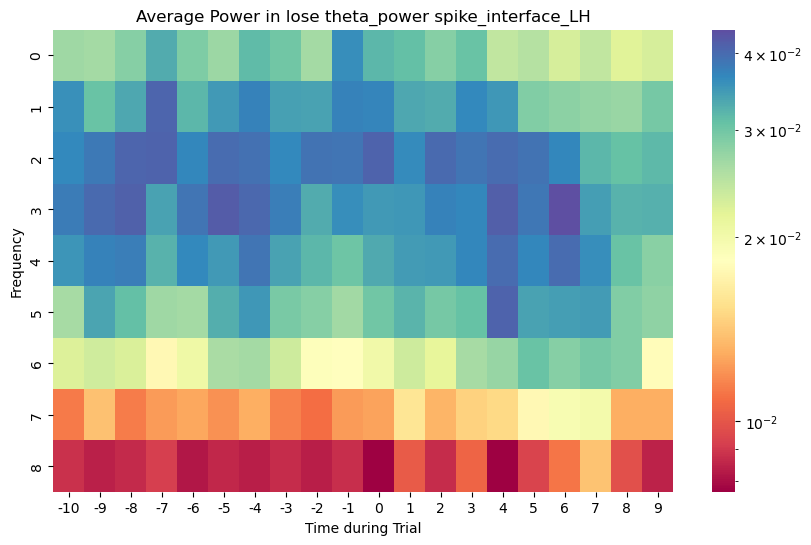

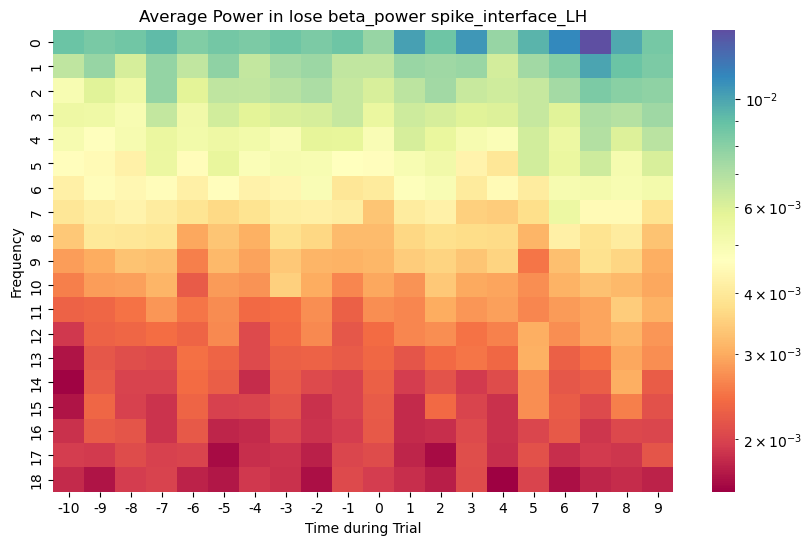

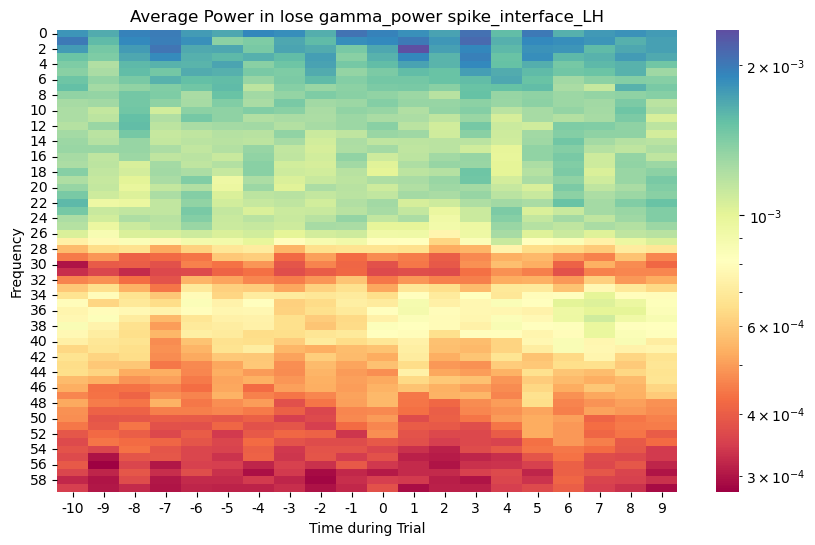

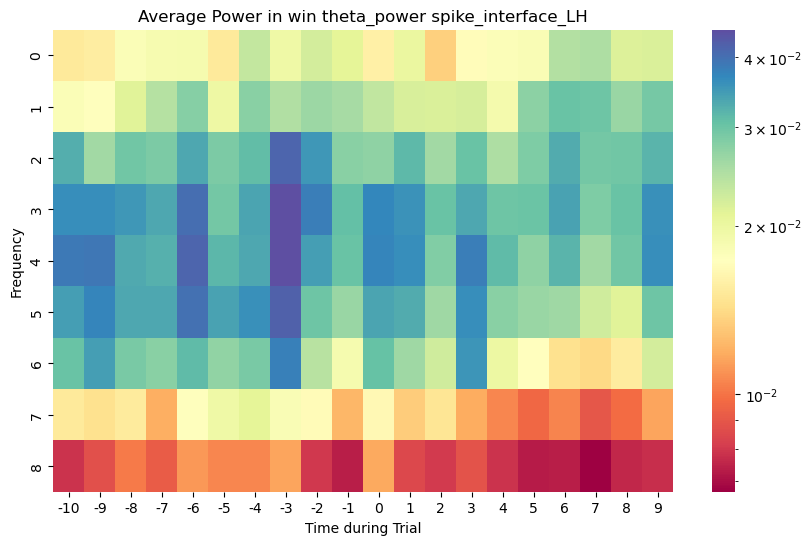

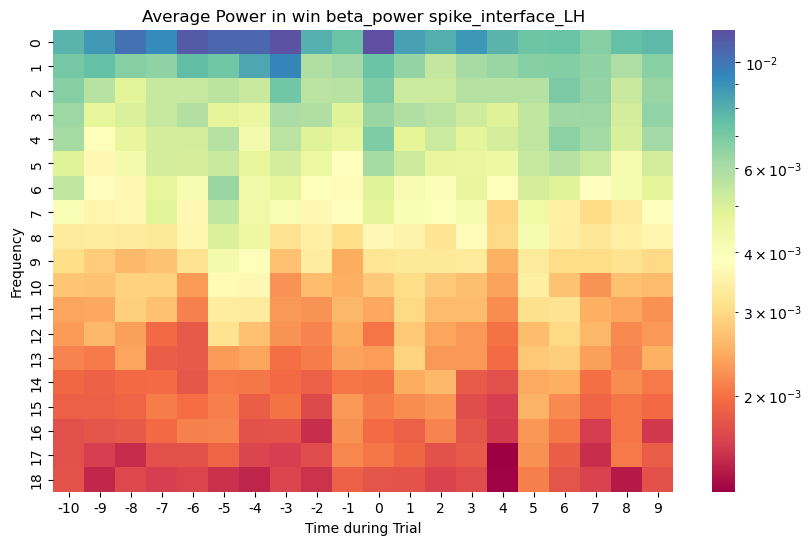

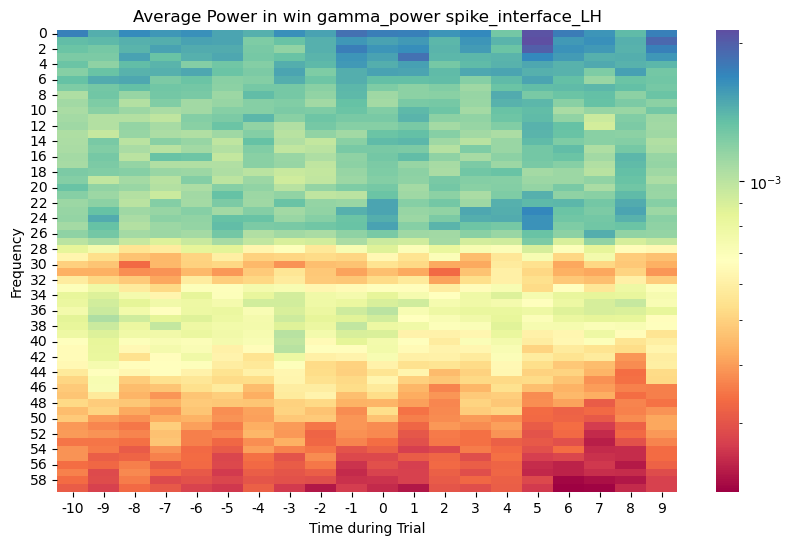

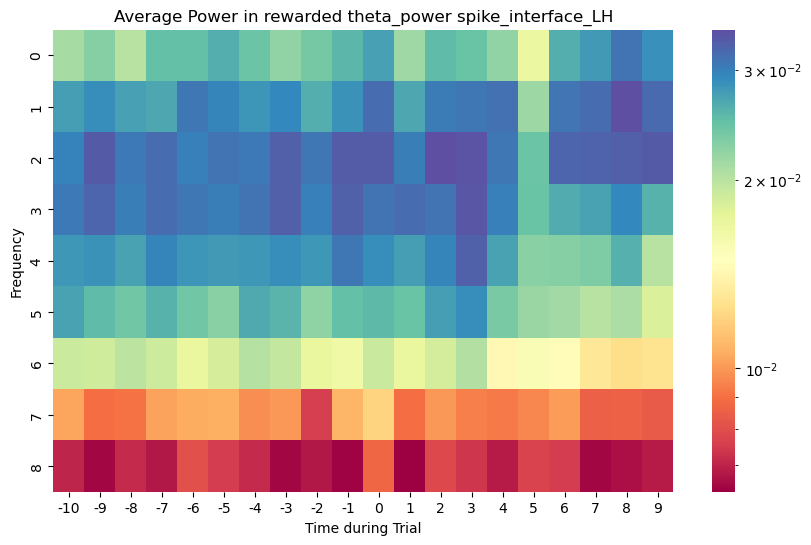

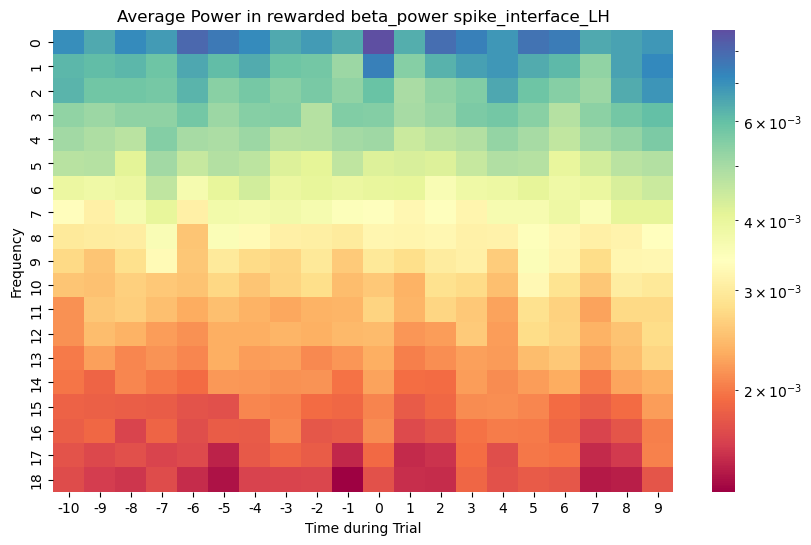

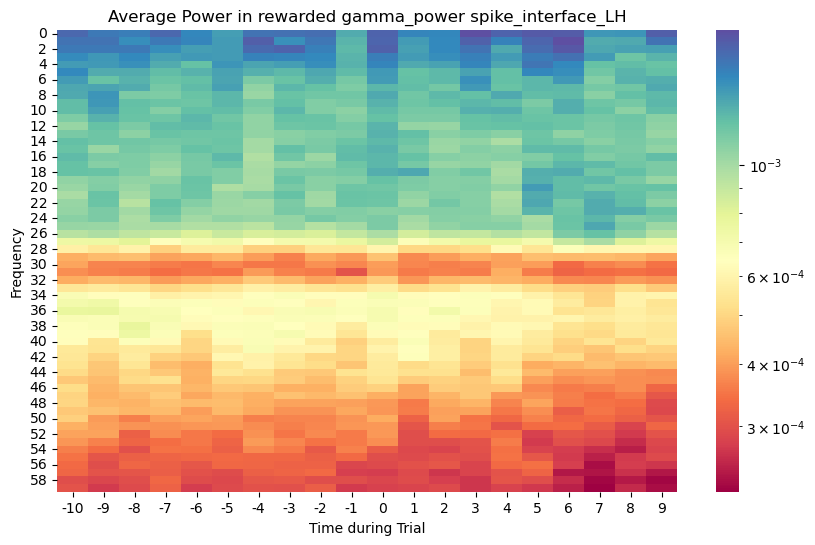

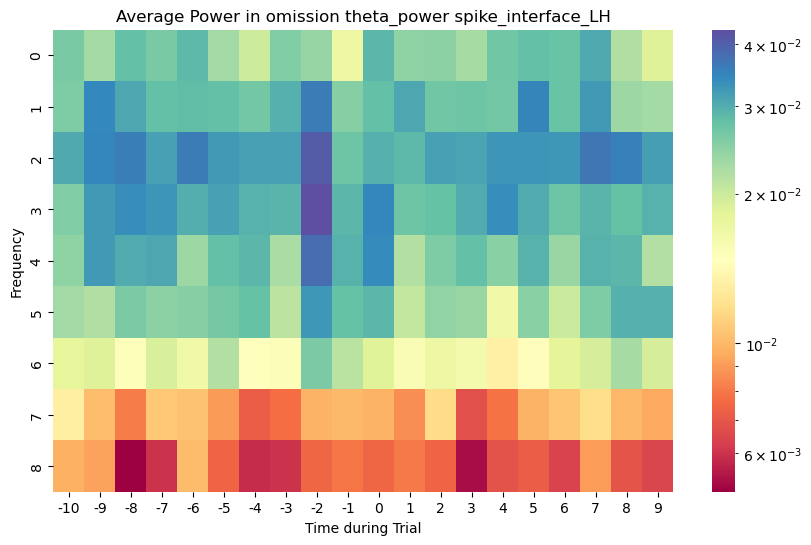

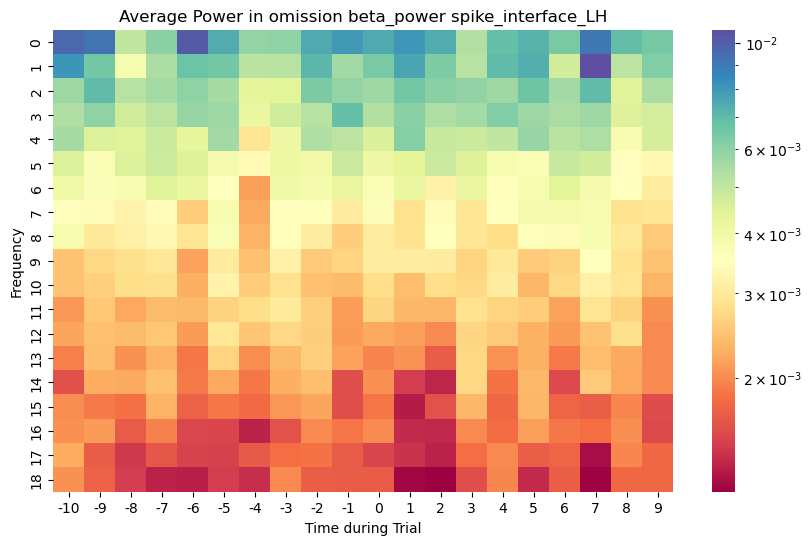

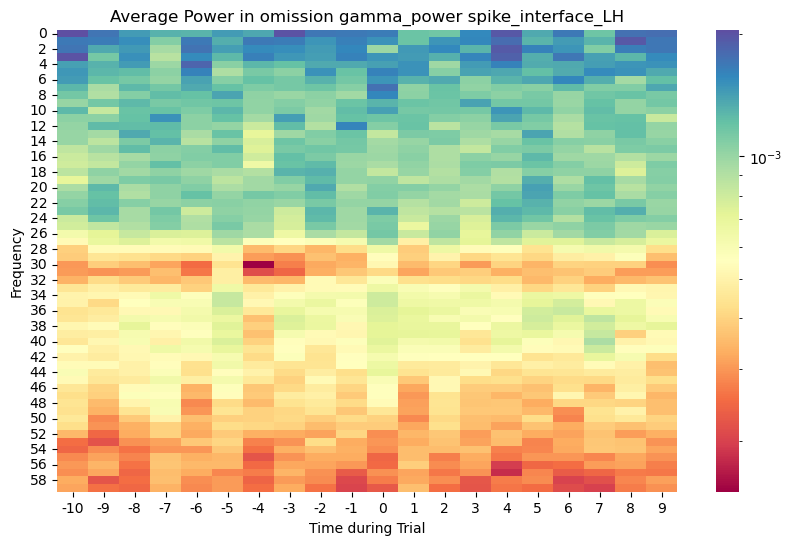

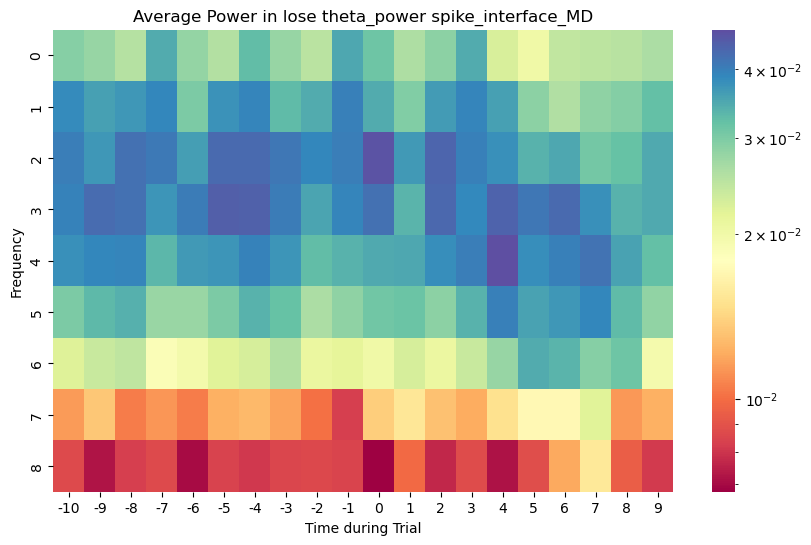

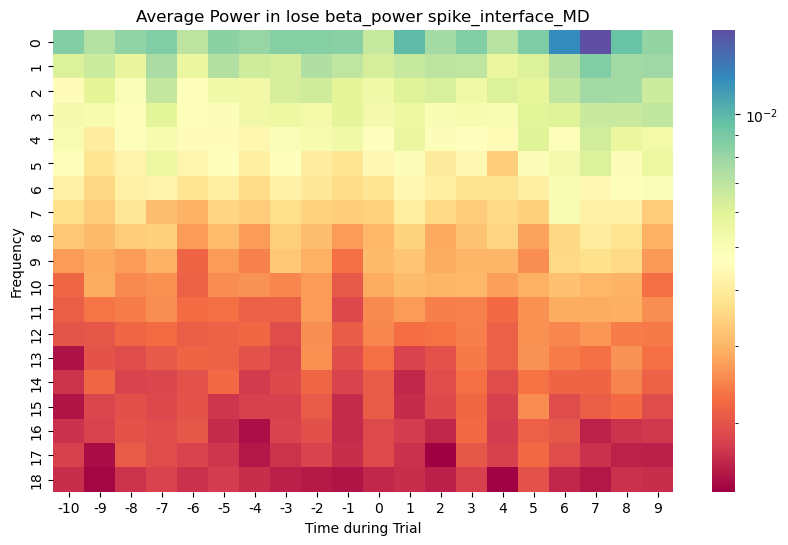

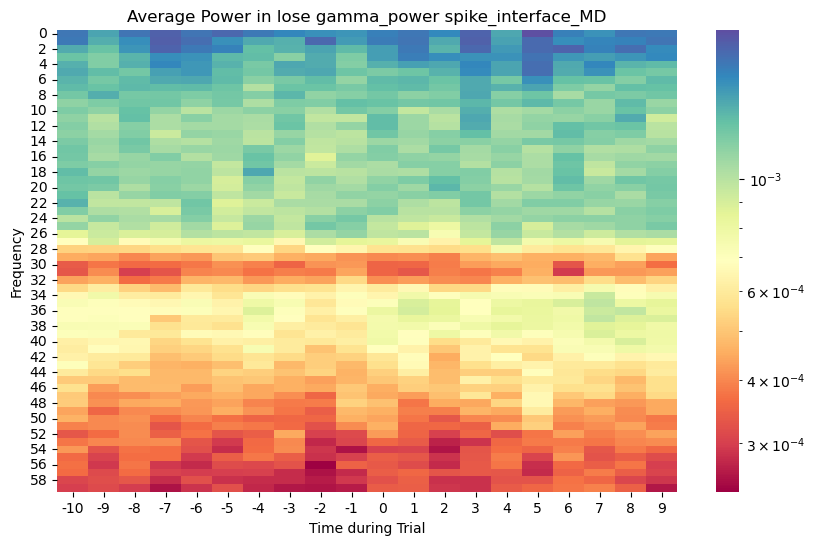

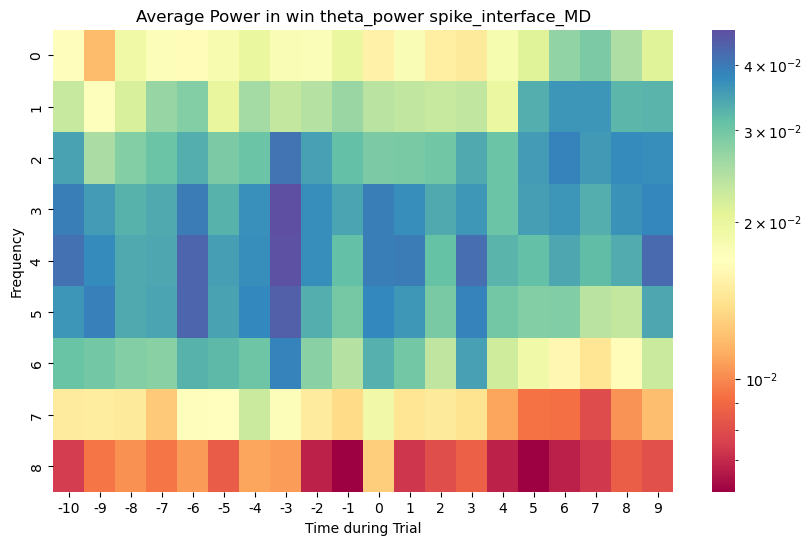

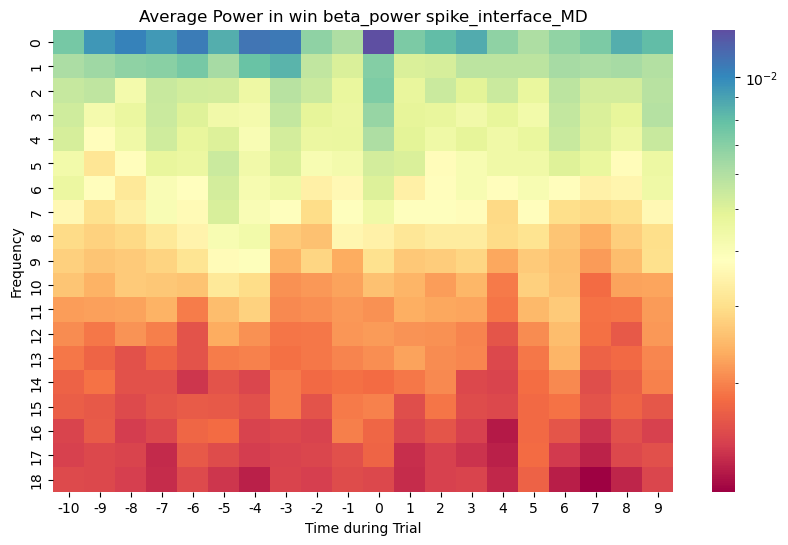

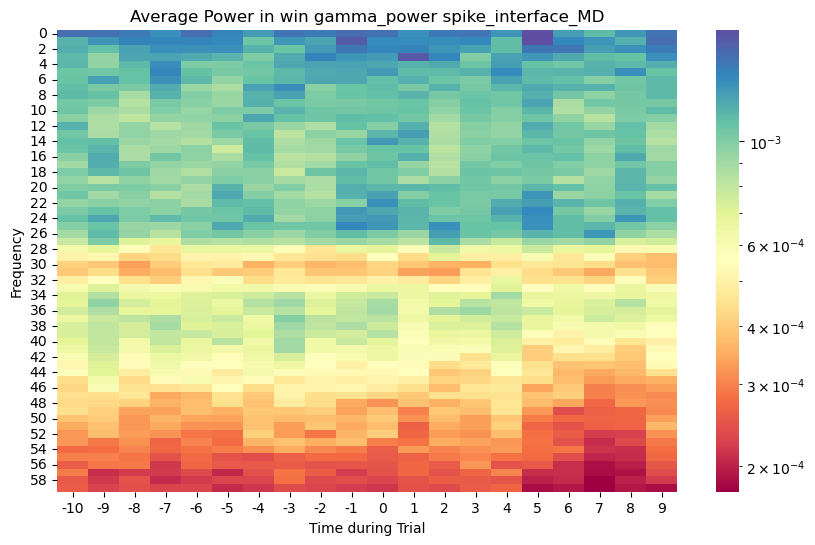

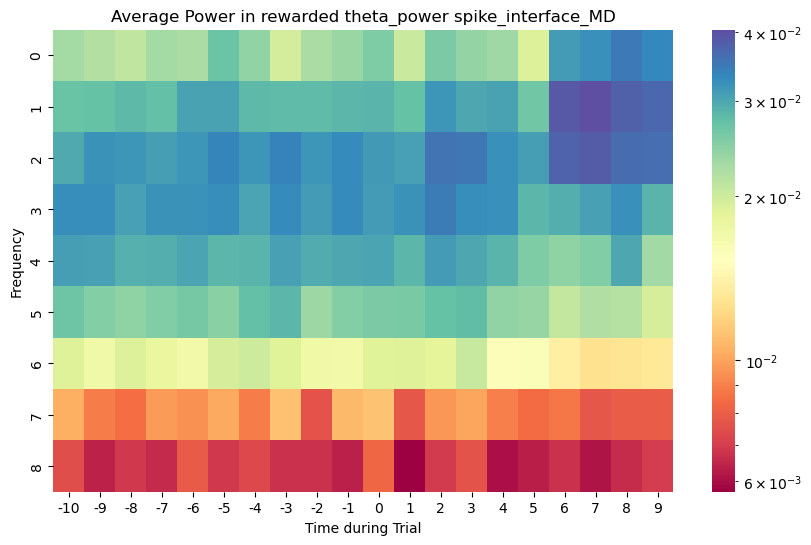

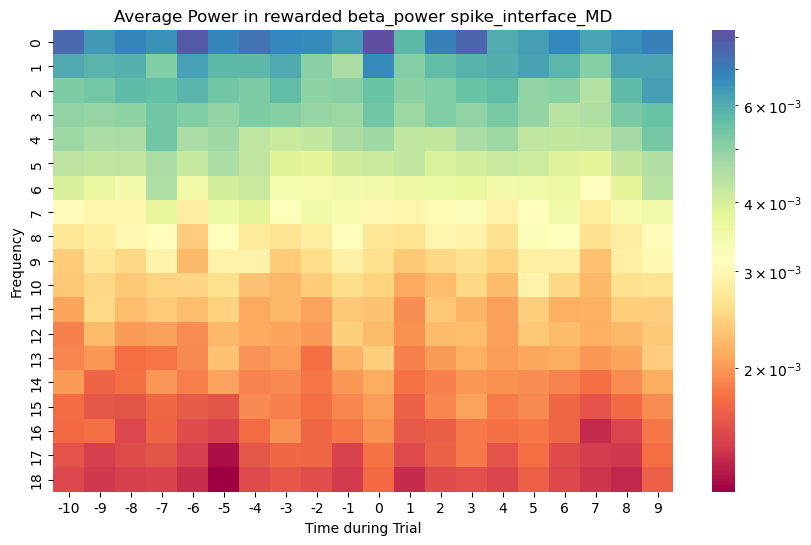

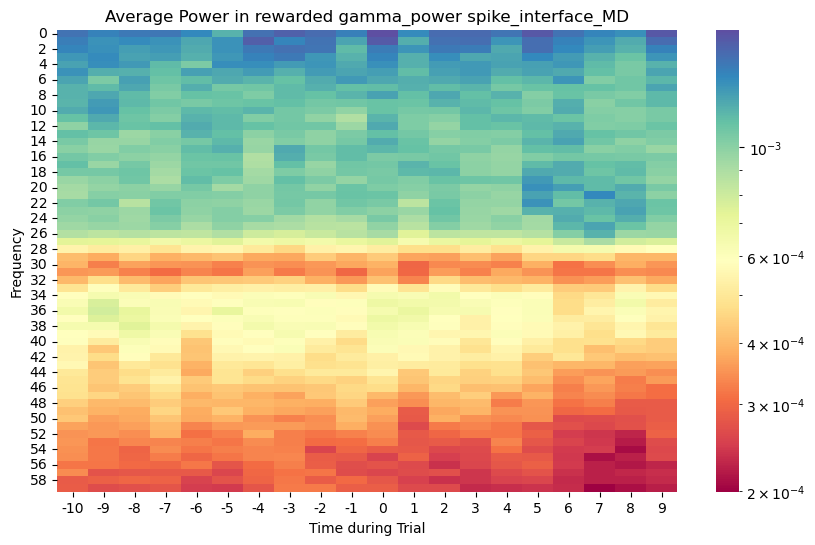

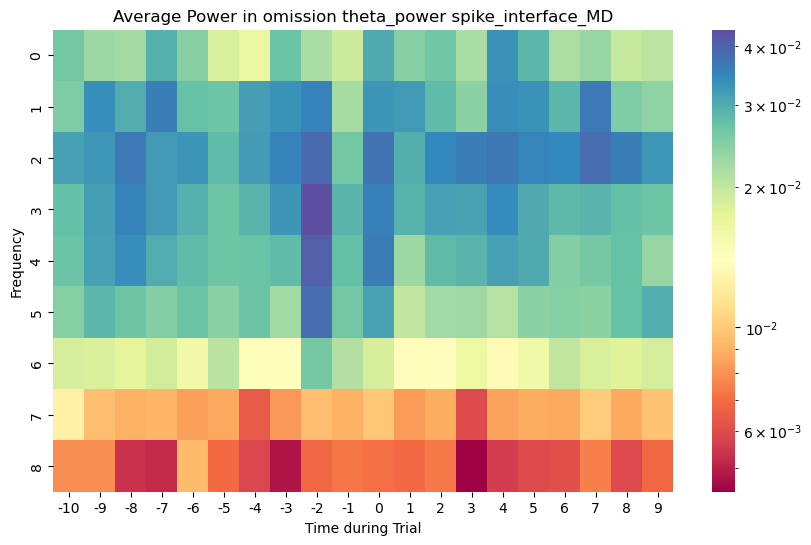

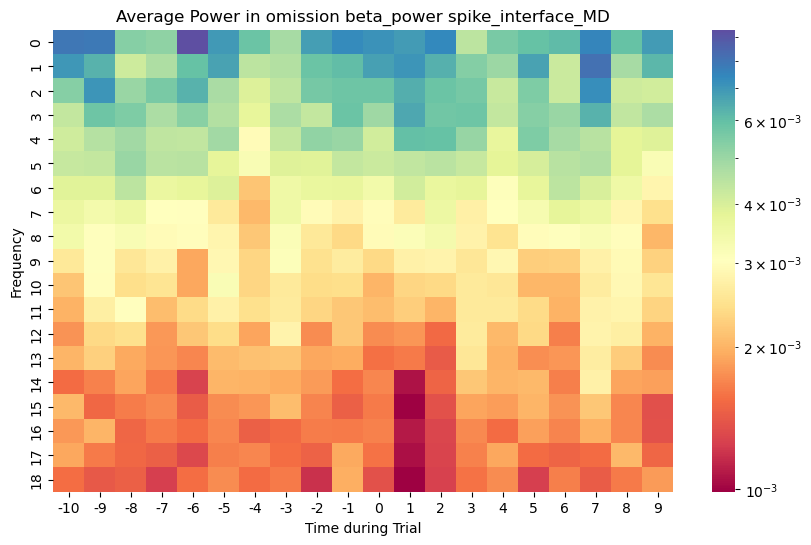

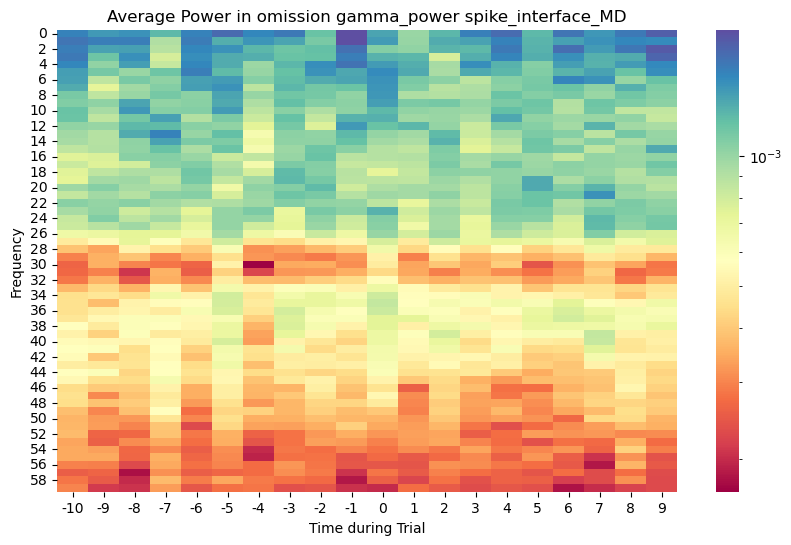

In [108]:
for brain_region, region_dict in outcome_to_region_to_groupings.items():
    for outcome, df in region_dict.items():
        for power in ALL_POWERS:
            # Expand the power values into a matrix
            power_matrix = np.vstack(df[power])
            
            # Assuming that each list in the 'power_values' column is the same length
            frequencies = range(len(df[power].iloc[0]))
            
            # Plotting
            plt.figure(figsize=(10, 6))
            # sns.heatmap(power_matrix.T, cmap='Blues', xticklabels=grouped_df['chunk_id'], yticklabels=frequencies)

            sns.heatmap(power_matrix.T, cmap='Spectral', xticklabels=grouped_df['chunk_id'], norm=colors.LogNorm(vmin=power_matrix.T.min(), vmax=power_matrix.T.max()))

            
            plt.xlabel('Time during Trial')
            plt.ylabel('Frequency')
            plt.title('Average Power in {} {} {}'.format(outcome, power, brain_region))
            plt.savefig("./proc/spectogram/{}_{}_{}.png".format(power, brain_region, outcome))
            plt.show()

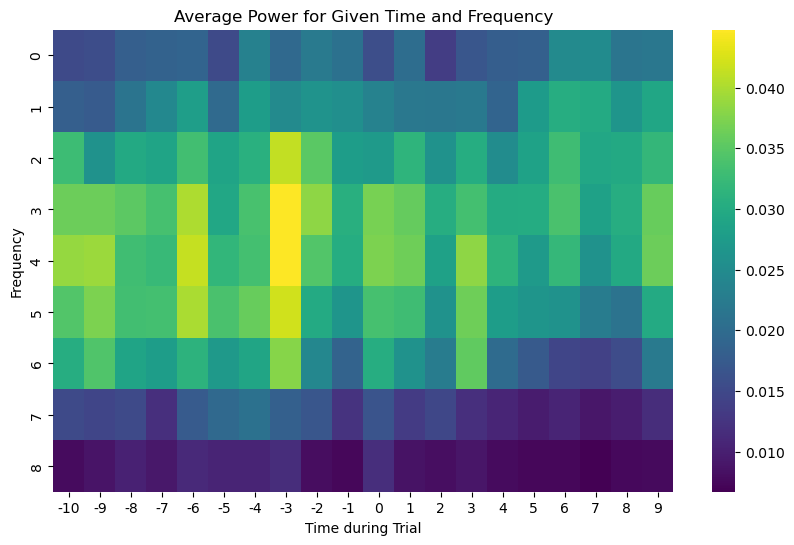

In [109]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



# Expand the power values into a matrix
power_matrix = np.vstack(grouped_df['theta_power'])

# Assuming that each list in the 'power_values' column is the same length
frequencies = range(len(grouped_df['theta_power'].iloc[0]))

# Plotting
plt.figure(figsize=(10, 6))
sns.heatmap(power_matrix.T, cmap='viridis', xticklabels=grouped_df['chunk_id'], yticklabels=frequencies)
plt.xlabel('Time during Trial')
plt.ylabel('Frequency')
plt.title('Average Power for Given Time and Frequency')
plt.show()

In [ ]:
df

In [ ]:
raise ValueError()

# Plotting all the higher velocities together

In [ ]:
speed_filtered_all_trials_df = exploded_channel_map_and_all_trials_df[exploded_channel_map_and_all_trials_df["binned_current_thorax_velocity"] == 1]

In [ ]:
exploded_channel_map_and_all_trials_df["theta_power"] = exploded_channel_map_and_all_trials_df["power"].apply(lambda x: x[4:13])

In [ ]:
exploded_channel_map_and_all_trials_df["theta_power"].iloc[0]

In [ ]:
exploded_channel_map_and_all_trials_df["averaged_theta_power"] = exploded_channel_map_and_all_trials_df["theta_power"].apply(lambda x: np.mean(x))

In [ ]:
exploded_channel_map_and_all_trials_df["averaged_theta_power"]

In [ ]:
exploded_channel_map_and_all_trials_df.columns

In [ ]:
exploded_channel_map_and_all_trials_df["all_thorax_velocity"].iloc[0].shape

In [ ]:
exploded_channel_map_and_all_trials_df.info()

In [ ]:
exploded_channel_map_and_all_trials_df.columns

In [ ]:
exploded_channel_map_and_all_trials_df["competition_closeness"] == 

In [ ]:
exploded_channel_map_and_all_trials_df["competition_closeness"]

In [ ]:
back_up_exploded_channel_map_and_all_trials_df = exploded_channel_map_and_all_trials_df.copy()

In [ ]:
exploded_channel_map_and_all_trials_df = exploded_channel_map_and_all_trials_df[~exploded_channel_map_and_all_trials_df["competition_closeness"].isin(['lose_non_comp', 'win_non_comp'])]

In [ ]:
exploded_channel_map_and_all_trials_df["brain_region"]

In [ ]:
exploded_channel_map_and_all_trials_df.drop(columns=["multitaper", "connectivity", 'all_thorax_locations', 'all_thorax_velocity', 'all_ch_lfp']).to_pickle("./proc/rce_1_sec_interval_lfp_power_spectra_and_velocity.pkl")

In [ ]:
grouped_all_trials_df = speed_filtered_all_trials_df.groupby(['brain_region', 'trial_outcome', 'trial_or_baseline']).agg({'power': lambda x: np.vstack(x.tolist())}).reset_index()

In [ ]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [ ]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

In [ ]:
exploded_channel_map_and_all_trials_df["frequencies"].iloc[0][4:13]

# Drawing plots all together

In [ ]:
low_freq = 0
high_freq = 12
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 5cm/s to 10cm/s".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)   
    plt.yscale("log")
    plt.ylim(0.01, 0.1)

    for trial_or_baseline, outcome in itertools.product(region_df["trial_or_baseline"].unique(), sorted(region_df["trial_outcome"].unique())[::-1]):
        outcome_df = region_df[(region_df["trial_or_baseline"] == trial_or_baseline) & (region_df["trial_outcome"] == outcome)]
        for index, row in outcome_df.iterrows():
            try:
                ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
                label="{} {}".format(outcome, trial_or_baseline), color=BASELINE_OUTCOME_TO_COLOR[outcome], \
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                
                plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
                row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
                alpha=0.2, color=BASELINE_OUTCOME_TO_COLOR[outcome])
            
            except Exception as e: 
                print(e)
                continue
    plt.legend()
    plt.savefig("./proc/velocity_parsing/plot_region_line_trialoutcome_baselinetrial/\
    rce_higher_velocity_lfp_power_trialoutcome_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))

In [ ]:
low_freq = 12
high_freq = 30
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 5cm/s to 10cm/s".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.002, 0.015) 
    
    for trial_or_baseline, outcome in itertools.product(region_df["trial_or_baseline"].unique(), sorted(region_df["trial_outcome"].unique())[::-1]):
        outcome_df = region_df[(region_df["trial_or_baseline"] == trial_or_baseline) & (region_df["trial_outcome"] == outcome)]
        for index, row in outcome_df.iterrows():
            try:
                ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
                label="{} {}".format(outcome, trial_or_baseline), color=BASELINE_OUTCOME_TO_COLOR[outcome], \
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                
                plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
                row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
                alpha=0.2, color=BASELINE_OUTCOME_TO_COLOR[outcome])
            
            except Exception as e: 
                print(e)
                continue
    plt.legend()
    plt.savefig("./proc/velocity_parsing/plot_region_line_trialoutcome_baselinetrial/\
    rce_higher_velocity_lfp_power_trialoutcome_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))

In [ ]:
low_freq = 30
high_freq = 90
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 5cm/s to 10cm/s".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.0003, 0.008) 
    
    for trial_or_baseline, outcome in itertools.product(region_df["trial_or_baseline"].unique(), sorted(region_df["trial_outcome"].unique())[::-1]):
        outcome_df = region_df[(region_df["trial_or_baseline"] == trial_or_baseline) & (region_df["trial_outcome"] == outcome)]
        for index, row in outcome_df.iterrows():
            try:
                ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
                label="{} {}".format(outcome, trial_or_baseline), color=BASELINE_OUTCOME_TO_COLOR[outcome], \
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                
                plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
                row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
                alpha=0.2, color=BASELINE_OUTCOME_TO_COLOR[outcome])
            
            except Exception as e: 
                print(e)
                continue
    plt.legend()
    plt.savefig("./proc/velocity_parsing/plot_region_line_trialoutcome_baselinetrial/\
    rce_higher_velocity_lfp_power_trialoutcome_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))

## Plotting all the competitiveness and lower velocities together

In [ ]:
speed_filtered_all_trials_df = exploded_channel_map_and_all_trials_df[exploded_channel_map_and_all_trials_df["binned_current_thorax_velocity"] == 0]

In [ ]:
speed_filtered_all_trials_df.shape

In [ ]:
grouped_all_trials_df = speed_filtered_all_trials_df.groupby(['brain_region', 'competition_closeness', 'trial_or_baseline']).agg({'power': lambda x: np.vstack(x.tolist())}).reset_index()

In [ ]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [ ]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

In [ ]:
grouped_all_trials_df["competition_closeness"].unique()

# Drawing plots all together

In [ ]:
region_df

In [ ]:
low_freq = 0
high_freq = 12
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 0 to 5cm/s".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)  
    plt.yscale("log")
    plt.ylim(0.01, 0.1) 


    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} {}".format(row["competition_closeness"], row["trial_or_baseline"]), color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]], \
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)
            
            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
            alpha=0.1, color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]])
        
        except Exception as e: 
            print(e)
            continue
    
    # Create a legend outside of the plot
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save the plot along with the legend outside of it   
    # plt.savefig("./proc/velocity_parsing/plot_region_line_competitioncloseness_baselinetrial/\
    # rce_lower_velocity_lfp_power_competitioncloseness_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]), bbox_extra_artists=(legend,), bbox_inches='tight')

    # Display the plot
    plt.show()


In [ ]:
low_freq = 12
high_freq = 30
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 0 to 5cm/s".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.002, 0.015) 

    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} {}".format(row["competition_closeness"], row["trial_or_baseline"]), color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]], \
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)
            
            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
            alpha=0.1, color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]])
        
        except Exception as e: 
            print(e)
            continue
            
    # Create a legend outside of the plot
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save the plot along with the legend outside of it   
    # plt.savefig("./proc/velocity_parsing/plot_region_line_competitioncloseness_baselinetrial/\
    # rce_lower_velocity_lfp_power_competitioncloseness_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]), bbox_extra_artists=(legend,), bbox_inches='tight')

    # Display the plot
    plt.show()

In [ ]:
low_freq = 30
high_freq = 90
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 0 to 5cm/s".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.0003, 0.005) 

    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} {}".format(row["competition_closeness"], row["trial_or_baseline"]), color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]], \
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)
            
            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
            alpha=0.1, color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]])
        
        except Exception as e: 
            print(e)
            continue
    # Create a legend outside of the plot
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save the plot along with the legend outside of it   
    # plt.savefig("./proc/velocity_parsing/plot_region_line_competitioncloseness_baselinetrial/\
    # rce_lower_velocity_lfp_power_competitioncloseness_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]), bbox_extra_artists=(legend,), bbox_inches='tight')

    # Display the plot
    plt.show()

## Plotting all the higher velocities together

In [ ]:
speed_filtered_all_trials_df = exploded_channel_map_and_all_trials_df[exploded_channel_map_and_all_trials_df["binned_current_thorax_velocity"] == 1]

In [ ]:
grouped_all_trials_df = speed_filtered_all_trials_df.groupby(['brain_region', 'competition_closeness', 'trial_or_baseline']).agg({'power': lambda x: np.vstack(x.tolist())}).reset_index()

In [ ]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [ ]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

# Drawing plots all together

In [ ]:
low_freq = 0
high_freq = 12
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 5cm/s to 10cm/s".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.01, 0.25) 

    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} {}".format(row["competition_closeness"], row["trial_or_baseline"]), color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]], \
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)
            
            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
            alpha=0.1, color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]])
        
        except Exception as e: 
            print(e)
            continue
    # Create a legend outside of the plot
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save the plot along with the legend outside of it   
    plt.savefig("./proc/velocity_parsing/plot_region_line_competitioncloseness_baselinetrial/\
    rce_higher_velocity_lfp_power_competitioncloseness_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]), bbox_extra_artists=(legend,), bbox_inches='tight')

    # Display the plot
    plt.show()

In [ ]:
low_freq = 12
high_freq = 30
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 5cm/s to 10cm/s".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.002, 0.015) 

    
    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} {}".format(row["competition_closeness"], row["trial_or_baseline"]), color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]], \
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)
            
            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
            alpha=0.1, color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]])
        
        except Exception as e: 
            print(e)
            continue
    # Create a legend outside of the plot
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save the plot along with the legend outside of it   
    plt.savefig("./proc/velocity_parsing/plot_region_line_competitioncloseness_baselinetrial/\
    rce_higher_velocity_lfp_power_competitioncloseness_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]), bbox_extra_artists=(legend,), bbox_inches='tight')

    # Display the plot
    plt.show()

In [ ]:
low_freq = 12
high_freq = 30
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 5cm/s to 10cm/s".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.002, 0.015) 
    
    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} {}".format(row["competition_closeness"], row["trial_or_baseline"]), color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]], \
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)
            
            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
            alpha=0.1, color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]])
        
        except Exception as e: 
            print(e)
            continue
    # Create a legend outside of the plot
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save the plot along with the legend outside of it   
    plt.savefig("./proc/velocity_parsing/plot_region_line_competitioncloseness_baselinetrial/\
    rce_higher_velocity_lfp_power_competitioncloseness_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]), bbox_extra_artists=(legend,), bbox_inches='tight')

    # Display the plot
    plt.show()

In [ ]:
low_freq = 30
high_freq = 90
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 5cm/s to 10cm/s".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.0003, 0.005) 
    
    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} {}".format(row["competition_closeness"], row["trial_or_baseline"]), color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]], \
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)
            
            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
            alpha=0.1, color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]])
        
        except Exception as e: 
            print(e)
            continue
            
    # Create a legend outside of the plot
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save the plot along with the legend outside of it   
    plt.savefig("./proc/velocity_parsing/plot_region_line_competitioncloseness_baselinetrial/\
    rce_higher_velocity_lfp_power_competitioncloseness_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]), bbox_extra_artists=(legend,), bbox_inches='tight')

    # Display the plot
    plt.show()

In [ ]:
exploded_channel_map_and_all_trials_df

In [ ]:
exploded_channel_map_and_all_trials_df.columns

In [ ]:
exploded_channel_map_and_all_trials_df["current_thorax_velocity"]

In [ ]:
melted_channel_map_and_all_trials_df["subject_id"].unique()

# Drawing Spectogram

In [ ]:
exploded_channel_map_and_all_trials_df["power"].iloc[0].shape

In [ ]:
exploded_channel_map_and_all_trials_df["brain_region"]

In [ ]:
exploded_channel_map_and_all_trials_df[""]

In [ ]:
grouped_all_trials_df

In [ ]:
exploded_channel_map_and_all_trials_df

In [ ]:
exploded_channel_map_and_all_trials_df["recording_file"].unique()

In [ ]:
exploded_channel_map_and_all_trials_df["subject_id"].unique()